In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
from pylab import cm, imshow, contour, clabel, colorbar
import matplotlib.image as mpimg
import matplotlib.lines as mlines
import glob
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir/mx1908

/Users/giulio/PNAS-resub/decaarginine/mx1908


# SAXS data

In [14]:
def plotiq(name,data,subplot,which='all',corr=1,c='red',ls=None):
    pep = name.split('-')[0]
    cs = float(name.split('-')[-1].split('m')[0])/1e3
    conv = 0
    if ls == None:
        ls ='-'
    if pep.split('8')[0] == 'R' or pep.split('1')[0] == 'R':
        conv = data['conv-factors']['R10']*corr
    if pep.split('8')[0] == 'K' or pep.split('1')[0] == 'K':
        conv = data['conv-factors']['K10']*corr
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'R':
        if ls == None:
            ls = '--'
    i = np.zeros((1043,))
    for n in which:
        cp, file = data[ name ][n]
        q, ii, e = np.loadtxt( file, unpack=True )
        i = i + ii
    q = q[10:]
    i = i[10:] / len(which) / conv
    e = e[10:]/conv
    lowessl = sm.nonparametric.lowess(i-e,q,frac=.1)
    lowessu = sm.nonparametric.lowess(i+e,q,frac=.1)
    lowess = sm.nonparametric.lowess(i,q,frac=.1)
    subplot.fill_between(lowess[:,0],lowessl[:,1],lowessu[:,1],color=c,alpha=0.2)
    subplot.plot(lowess[:,0],lowess[:,1],color=c,lw=2,linestyle=ls,
             label='$c_p={:1.0f}$'.format(cp*conv)+' g/l') 
    subplot.legend(loc='upper right', frameon=False,ncol=1,
                   handletextpad=0.4,handlelength=1.5,title='$c_s={:1.3f}$'.format(cs)+' M')
    subplot.get_legend().get_title().set_fontsize('14')
    subplot.set_ylabel(r'$I(q)$ / $c_p$')
    subplot.set_xticks([0,1,2,3,4])
    subplot.set_yticks([0,.5,1,1.5,2,2.5])
    subplot.set_ylim(0,2.5)
    subplot.set_xlim(0,4.5)

In [15]:
def plotiq_cs(name,data,subplot,which='all',corr=1,c='red',ls=None):
    pep = name.split('-')[0]
    cs = float(name.split('-')[1].split('m')[0])/1e3
    conv = 0
    if ls == None:
        ls ='-'
    if pep.split('8')[0] == 'R' or pep.split('1')[0] == 'R':
        conv = data['conv-factors']['R10']*corr
    if pep.split('8')[0] == 'K' or pep.split('1')[0] == 'K':
        conv = data['conv-factors']['K10']*corr
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'R':
        if ls == None:
            ls = '--'
    q_m = np.empty((1043,))
    for n in which:
        cp, file = data[ name ][n]
        r, q, x = np.loadtxt( file, unpack=True )
        q_m = q_m + q
    q_m = q_m / len(which)
    r = r[10:]
    q = q[10:]/conv
    x = x[10:]/conv
    lowessl = sm.nonparametric.lowess(q-x,r,frac=.1)
    lowessu = sm.nonparametric.lowess(q+x,r,frac=.1)
    lowess = sm.nonparametric.lowess(q,r,frac=.1)
    subplot.fill_between(lowess[:,0],lowessl[:,1],lowessu[:,1],color=c,alpha=0.2)
    subplot.plot(lowess[:,0],lowess[:,1],color=c,lw=2,linestyle=ls,
             label='$c_p={:1.0f}$'.format(cp*conv)+' g/l,\n$c_s={:1.3f}$'.format(cs)+' M') 
    subplot.legend(loc='upper right', frameon=False,ncol=1,
                   handletextpad=0.4,handlelength=1.5)
    subplot.get_legend().get_title().set_fontsize('14')
    subplot.set_ylabel(r'$I(q)$ / $c_p$')
    subplot.set_xticks([0,1,2,3,4])
    subplot.set_yticks([0,.5,1,1.5,2,2.5])
    subplot.set_ylim(0,2.5)
    subplot.set_xlim(0,4.5)

In [16]:
def plotI0inv(filename,sub,mw,c,l=''):

    i0 = np.loadtxt('b2/i0_'+filename+'.dat',comments={'#','S','P'},usecols=(0,1,2))
    
    name = float(filename.split('-')[-1].split('m')[0])/1000
    
    sub.errorbar(i0[:,0]/mw,1./i0[:,1],i0[:,2]/i0[:,1]/i0[:,1],color=c,lw=0.5,marker='o',
                 markeredgecolor=c,alpha=1,label='{:1.3f}'.format(name)+' M'+l,ms=8,
                 elinewidth=1.,capsize=2,capthick=1.)

    sub.set_xlabel(r'$c_p$ / mM')
    sub.set_ylabel(r'$c_p$ / $I(0)$')

In [17]:
def plotI0(data,name,corra=[1,1,1,1,1],colors=['r', 'b', 'g', 'k','m','y']):
    x = np.arange(0,.3,.01)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    pmax = 56
    pmin = 10
    
    pep = name.split('-')[0]
    conv = 0
    mw = 0
    if pep.split('8')[0] == 'R' or pep.split('1')[0] == 'R':
        mw = 1.580
        conv = data['conv-factors']['R10']
    if pep.split('8')[0] == 'K' or pep.split('1')[0] == 'K':
        mw = 1.300
        conv = data['conv-factors']['K10']
    cs = name.split('-')[1]
    plt.title(name)
    i0 = np.zeros((len(data[name]),3)) # Intensity at q = 0
    for pair,corr,c in zip(data[ name ],corra,colors):
        cp, file = pair
        q, i, e = np.loadtxt( file, unpack=True )
        cf = conv * corr
        axes[0].plot(q[5:],np.log(i[5:]/cf),lw=0,marker='^',markevery=1,
                 label='$c_p$={:1.1f}'.format(cp*cf/mw)+' mM',c=c)
        axes[1].plot(q[pmin:pmax],i[pmin:pmax]/cf,lw=0,marker='^',
                     markevery=1,ms=10,c=c)
        ipt = (i[pmin:pmax]/cf).mean()
        err = (e[pmin:pmax]/cf).mean()
        axes[1].plot(x,np.repeat(ipt,x.size),c=c)
        if (cp*cf in i0[:,0]):
            idx = np.array(i0[:,0]).tolist().index(cp*cf)
            i0[idx,1] = (i0[idx,1] + ipt)/2.
            i0[idx,2] = np.abs(i0[idx,1] - ipt)/2. + err + i0[idx,2]
        else:
            idx = i0[:,0].nonzero()[0].size
            i0[idx,0] = cp*cf
            i0[idx,1] = ipt
            i0[idx,2] = err   
    indeces = np.nonzero(i0[:,0])
    i0 = i0[indeces]
    i0 = i0[i0[:,0].argsort()]
    axes[0].set_ylabel("ln($I(q)$)")
    axes[1].set_ylabel("$I(q)$")
    for i in range(2):
        axes[i].set_xlabel("$q$  / nm$^{-1}$")
        axes[i].legend()
    axes[0].axvline(x=.10,lw=2,c='k')
    axes[0].axvline(x=.3,lw=2,c='k')
    axes[0].set_ylim(-4,1)
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position('right')
    fig.tight_layout()
    #fig.savefig('ranges_'+name+'.png') 
    fig.show()
    np.savetxt('b2/i0_'+name+'.dat',i0)

In [18]:
def plotWat(c='black',m='o',minq=0,maxq=1000):
    def f(x,a,b,c,d,e,g):
        return a+b*x+c*x*x+d*x*x*x+e*x*x*x*x+g*x*x*x*x*x
    q, i, e = np.loadtxt('/Users/giulio/Dropbox/ecis/mx1908/WATER_/average/1.0_mgml_water_005_ave.dat', unpack=True )
    
    x = np.linspace(0,5,100) 
    plt.ylabel("$I(q)$")
    plt.xlabel("$q$  / nm$^{-1}$")
    plt.plot(q[minq:maxq],i[minq:maxq],color=c,lw=1,
             marker=m,markevery=20,alpha=0.5,mec=c,markersize=5)
    fit_par = curve_fit(f,q[minq:maxq],i[minq:maxq],
                        sigma=e[minq:maxq])
    a = fit_par[0][0]
    b = fit_par[0][1]
    c = fit_par[0][2]
    d = fit_par[0][3]
    e = fit_par[0][4]
    g = fit_par[0][5]
    y = f(x,a,b,c,d,e,g)
    plt.plot(x,y,color='black',lw=1)
    return a

def plotGuinier(name,data,subplot,pepdata,which='all',corr=1,c='red',ls=None):
    pep = name.split('-')[0]
    cs = float(name.split('-')[1].split('m')[0])/1e3
    conv = 0
    NA = 6.022e23
    abs_scat = 0.01637
    be = 2.8179 * 1e-13
    rho_na = 9.52*1e10
    pepname = pep
    if ls == None:
        ls ='-'
    if pep.split('8')[0] == 'R' or pep.split('1')[0] == 'R':
        conv = data['conv-factors']['R10']*corr
    if pep.split('8')[0] == 'K' or pep.split('1')[0] == 'K':
        conv = data['conv-factors']['K10']*corr
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'R':
        pepname = pepname + 'KR'
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'K':
        pepname = pepname + 'RK'
    i = np.zeros((1043,))
    for n in which:
        cp, file = data[ name ][n]
        q, ii, e = np.loadtxt( file, unpack=True )
        i = i + ii
    q = q[10:350]
    i = i[10:350] / len(which) * cp
    e = e[10:350] * cp
        
    def f(x,rg2,lnI0):
        return -1/3*rg2*x+lnI0
    
    x = np.linspace(0,3.0,100) 
    plt.ylabel("ln$I(q)$")
    plt.xlabel("$q^2$  / nm$^{-2}$")
    
    plt.errorbar(q**2,np.log(i),e/i,color=c,lw=1,marker='o',ecolor=c,mec=c,ms=2,
                 markevery=10,errorevery=10,label=pepname+", $c_p={:2.0f}$".format(cp)+" g/l")
    popt,pcov = curve_fit(f,q**2,np.log(i),sigma=e/i)
    rg2 = popt[0]
    lnI0 = popt[1]
    rg = np.sqrt(rg2)
    I0 = np.exp(lnI0)
    perr = np.sqrt(np.diag(pcov))
    rgerr = 0.5*perr[0]/rg
    I0err = I0*perr[1]
    print('Guinier Analysis for '+pep)
    print('R_g','\t\t\t','I(0)','\t\t\t','conc')
    print('{:1.3f}'.format(rg),' +/- ','{:1.3f}'.format(rgerr),
          '\t','{:1.2f}'.format(I0),' +/- ','{:1.2f}'.format(I0err),
          '\t','{:2.1f}'.format(cp),'g/l')    
    y = f(x,rg2,lnI0)
    plt.plot(x,y,color='black', lw=1)
    rho_m = pepdata[pep]['#el'] / pepdata[pep]['mw'] * NA * be / pepdata[pep]['v']
    Drho = rho_m - rho_na
    factor = (Drho*Drho*pepdata[pep]['v']*pepdata[pep]['v']/NA*a16/abs_scat)*1e-3
    Mcalc = I0 / factor / cp / conv
    Mcalc_err = I0err / factor / cp / conv
    print('Calculated M_w of '+pep+': ','{:4.0f}'.format(Mcalc),'+/-','{:4.0f}'.format(Mcalc_err))
    print(pep+' - ratio calculated M_w / experimental M_w:',Mcalc/pepdata[pep]['mw'])
    print('Relative Error:',abs((Mcalc-pepdata[pep]['mw']) / pepdata[pep]['mw']*100 ),'%')
    print('........................................................')
    
def plotFF(name,data,subplot,which='all',corr=1,c='red',ls=None):
    pep = name.split('-')[0]
    cs = float(name.split('-')[1].split('m')[0])/1e3
    conv = 0
    pepname = pep
    if ls == None:
        ls ='-'
    if pep.split('8')[0] == 'R' or pep.split('1')[0] == 'R':
        conv = data['conv-factors']['R10']*corr
    if pep.split('8')[0] == 'K' or pep.split('1')[0] == 'K':
        conv = data['conv-factors']['K10']*corr
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'R':
        pepname = pepname + 'KR'
        if ls == None:
            ls = '--'
    if pep.split('8')[0] == 'K':
        pepname = pepname + 'RK'
    i = np.zeros((1043,))
    for n in which:
        cp, file = data[ name ][n]
        q, ii, e = np.loadtxt( file, unpack=True )
        i = i + ii
    q = q[0:1400]
    i = i[0:1400] / len(which) * cp
    e = e[0:1400] * cp
    
    plt.ylabel("$I(q)$")
    plt.xlabel("$q$  / nm$^{-1}$")
    plt.fill_between(q,i-e,i+e,color=c,alpha=0.2)
    plt.plot(q,i,color=c,lw=2,linestyle=ls,
             label=pepname+", $c_p={:2.0f}$".format(cp)+" g/l") 

In [19]:
# Experiments performed in November 2016
# tuple format: (cp_org, filename)
# concentration values in the raw data files are 1 mm absorbance at 214 nm 
data = {
        'conv-factors': {
            'K10': 1.64/0.94*1.308, 'R10': 1.64/1.08*1.588
        },
        'K8-25mM': [
            ( 2.05,  'k821_k82/subtraction/2.05_mgml_mM25_013_sub.dat' ),
            ( 2.05,  'k821_k82/subtraction/2.05_a_mgml_mM25_015_sub.dat' ),
            ( 3.83,   'k822_k82/subtraction/3.83_mgml_mM25_017_sub.dat' ),
            ( 7.08,  'k823_k82/subtraction/7.08_mgml_mM25_019_sub.dat' )
        ],
        'K8-150mM': [
            ( 2.18,  'k811_k81/subtraction/2.18_a_mgml_mM150_059_sub.dat'),
            ( 2.18,  'k811_k81/subtraction/2.18_mgml_mM150_057_sub.dat'),
            ( 4.27,  'k812_k81/subtraction/4.27_mgml_mM150_061_sub.dat'),
            ( 8.31,  'k813_k81/subtraction/8.31_mgml_mM150_063_sub.dat'),
            ( 14.01, 'k813_k81/subtraction/14.01_mgml_mM150_065_sub.dat')
        ],
        'K8-300mM': [
            (1.91,  'k831_k83_2/subtraction/1.91_mgml_mM300_203_sub.dat'),
            (3.37,  'k832_k83_2/subtraction/3.37_mgml_mM300_201_sub.dat'),
            (6.26,   'k833_k83_2/subtraction/6.26_mgml_mM300_205_sub.dat'),
            (11.85, 'k834_k83_2/subtraction/11.85_mgml_mM300_207_sub.dat')
        ],
        'R8-25mM': [
            (2.22,  'r821_r82/subtraction/2.22_mgml_mM25_025_sub.dat'),
            (2.22,  'r821_r82/subtraction/2.22_a_mgml_mM25_027_sub.dat'),
            (2.93,  'r822_r82/subtraction/2.93_mgml_mM25_029_sub.dat'),
            (5.86,  'r823_r82/subtraction/5.86_mgml_mM25_031_sub.dat'),
            (8.76,  'r824_r82/subtraction/8.76_mgml_mM25_033_sub.dat')
        ],
        'R8-150mM': [
            ( 2.4,   'r811_r81/subtraction/2.4_a_mgml_mM150_081_sub.dat'),
            ( 2.4,   'r811_r81/subtraction/2.4_mgml_mM150_079_sub.dat'),
            ( 4.2,   'r812_r81/subtraction/4.2_mgml_mM150_083_sub.dat'),
            ( 7.8,   'r813_r81/subtraction/7.8_mgml_mM150_085_sub.dat'),
            ( 14.1,  'r814_r81/subtraction/14.1_mgml_mM150_087_sub.dat')
        ],
        'R8-300mM': [
            ( 2.48,  'r831_r83/subtraction/2.48_mgml_mM300_126_sub.dat'),
            ( 2.48,  'r831_r83/subtraction/2.48_a_mgml_mM300_128_sub.dat'),
            ( 4.2,   'r832_r83/subtraction/4.2_mgml_mM300_130_sub.dat'),
            ( 8.3,   'r833_r83/subtraction/8.3_mgml_mM300_132_sub.dat'),
            ( 12.38, 'r834_r83/subtraction/12.38_mgml_mM300_136_sub.dat')
        ],
        'K10-25mM': [
            (1.93,  'k121_k12/subtraction/1.93_mgml_mM25_002_sub.dat'),
            (1.93,  'k121_k12/subtraction/1.93_a_mgml_mM25_004_sub.dat'),
            (3.87,  'k122_k12/subtraction/3.87_mgml_mM25_006_sub.dat'),
            (6.99,  'k123_k12/subtraction/6.99_mgml_mM25_008_sub.dat'),
            (10.27,  'k124_k12/subtraction/10.27_mgml_mM25_010_sub.dat'),
        ],
        'K10-60mM': [
            ( 1.93,  'k161_k16/subtraction/1.93_a_mgml_mM60_028_sub.dat' ),
            ( 1.93,  'k161_k16/subtraction/1.93_mgml_mM60_026_sub.dat' ),
            ( 4.42,  'k162_k16/subtraction/4.42_mgml_mM60_030_sub.dat' ),
            ( 8.63,  'k163_k16/subtraction/8.63_mgml_mM60_032_sub.dat' ),
            ( 13.71, 'k164_k16/subtraction/13.71_mgml_mM60_034_sub.dat' )
        ],
        'K10-150mM': [
            ( 2.05,   'k111_k11/subtraction/2.05_a_mgml_mM150_070_sub.dat'),
            ( 2.05,   'k111_k11/subtraction/2.05_mgml_mM150_068_sub.dat'),
            ( 4.33,   'k112_k11/subtraction/4.33_mgml_mM150_072_sub.dat'),
            ( 8.44,   'k113_k11/subtraction/8.44_mgml_mM150_074_sub.dat'),
            ( 13.56,  'k114_k11/subtraction/13.56_mgml_mM150_076_sub.dat')
        ],
        'K10-300mM': [
            ( 2.85,  'k131_k13/subtraction/2.85_a_mgml_mM300_106_sub.dat'),
            ( 2.85,  'k131_k13/subtraction/2.85_mgml_mM300_104_sub.dat'),
            ( 4.97,  'k132_k13/subtraction/4.97_mgml_mM300_108_sub.dat'),
            ( 10.03,  'k133_k13/subtraction/10.03_mgml_mM300_110_sub.dat')
        ],
        'R10-25mM': [
            ( 2.1,  'r121_r12/subtraction/2.1_mgml_mM25_036_sub.dat' ),
            ( 2.1,  'r121_r12/subtraction/2.1_a_mgml_mM25_038_sub.dat' ),
            ( 2.58,  'r122_r12/subtraction/2.58_mgml_mM25_041_sub.dat' ),
            ( 5.15,  'r123_r12/subtraction/5.15_mgml_mM25_043_sub.dat' ),
            ( 7.75, 'r124_r12/subtraction/7.75_mgml_mM25_045_sub.dat' )
        ],
        'R10-60mM': [
            ( 3.35,  'r161_r16/subtraction/3.35_mgml_mM60_011_sub.dat' ),
            ( 5.68,  'r162_r16/subtraction/5.68_mgml_mM60_014_sub.dat' ),
            ( 9.63,  'r163_r16/subtraction/9.63_mgml_mM60_016_sub.dat' ),
            ( 13.11, 'r164_r16/subtraction/13.11_mgml_mM60_023_sub.dat' )
        ],
        'R10-150mM': [
            ( 2.73,  'r111_r11/subtraction/2.73_a_mgml_mM150_092_sub.dat'),
            ( 2.73,  'r111_r11/subtraction/2.73_mgml_mM150_090_sub.dat'),
            ( 4.9,   'r112_r11/subtraction/4.9_mgml_mM150_094_sub.dat'),
            ( 10.22, 'r113_r11/subtraction/10.22_mgml_mM150_098_sub.dat'),
            ( 19.87, 'r114_r11/subtraction/19.87_mgml_mM150_101_sub.dat')
        ],
        'R10-300mM': [
            ( 2.4,  'r131_r13/subtraction/2.4_a_mgml_mM300_141_sub.dat'),
            ( 2.4,  'r131_r13/subtraction/2.4_mgml_mM300_139_sub.dat'),
            ( 4.06, 'r132_r13/subtraction/4.06_mgml_mM300_143_sub.dat'),
            ( 7.95, 'r133_r13/subtraction/7.95_mgml_mM300_145_sub.dat'),
            ( 7.95, 'r133_r13/subtraction/7.95_mgml_mM300_148_sub.dat'),
            ( 15.5, 'r134_r13/subtraction/15.5_mgml_mM300_151_sub.dat')
        ],
        'R10-Ac-25mM': [
            ( 2.59,  'r1a1_r1a/subtraction/2.59_mgml_mM30Acetate_095_sub.dat' ),
            ( 2.59,  'r1a1_r1a/subtraction/2.59_a_mgml_mM30Acetate_097_sub.dat' ),
            ( 4.53, 'r1a2_r1a/subtraction/4.53_mgml_mM30Acetate_099_sub.dat' ),
            ( 8.0, 'r1a3_r1a/subtraction/8.0_mgml_mM30Acetate_101_sub.dat' )
        ],
        'R8-Ac-25mM': [
            ( 2.43,  'r8a1_r8a/subtraction/2.43_mgml_mM30Acetate_104_sub.dat' ),
            ( 2.43,  'r8a1_r8a/subtraction/2.43_a_mgml_mM30Acetate_106_sub.dat' ),
            ( 4.58,  'r8a2_r8a/subtraction/4.58_mgml_mM30Acetate_108_sub.dat' ),
            ( 7.87,  'r8a3_r8a/subtraction/7.87_mgml_mM30Acetate_110_sub.dat' ),
            ( 11.14, 'r8a4_r8a/subtraction/11.14_mgml_mM30Acetate_112_sub.dat' )
        ]
}

pepdata = {
        'R10': { 'mw': 1580, 'v': .8, '#el': 850 },
        'K10': { 'mw': 1300, 'v': .84, '#el': 710 },
        'R8': { 'mw': 1552, 'v': .8, '#el': 836 },
        'K8': { 'mw': 1328, 'v': .84, '#el': 724 }
        }

### Extrapolation of $I(0)$

/Users/giulio/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/giulio/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/giulio/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


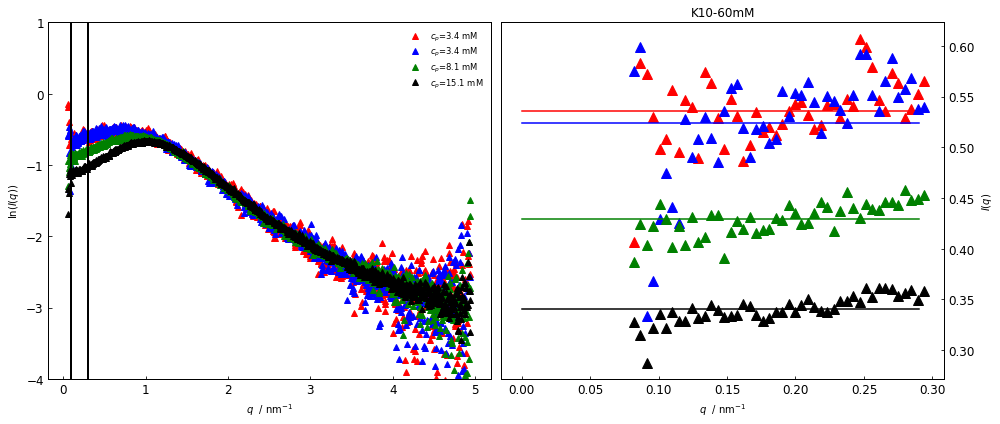

In [20]:
#plotI0(data,'R10-60mM',corra=[1.05,1.05,1,1])
plotI0(data,'K10-60mM',corra=[1,1,1.05,1])
#plotI0(data,'R10-150mM',corra=[1,1,1,1.05,1.05])
#plotI0(data,'K10-150mM',corra=[1,1.02,1,1,1])
#plotI0(data,'R10-25mM',corra=[1,1,1,1,1,1])
#plotI0(data,'K10-25mM',corra=[1,1,1,1,1,1])
#plotI0(data,'R10-300mM',corra=[1,1,1,1,1,1])
#plotI0(data,'K10-300mM',corra=[1,1,1,1,1,1])
#plotI0(data,'R8-25mM',corra=[1,1,1,1,1,1])
#plotI0(data,'R8-150mM',corra=[1,1,1,1.02,1.02,1])
#plotI0(data,'R8-300mM',corra=[1,1,1,1,1,1])
#plotI0(data,'K8-25mM',corra=[1.05,1.05,1,1,1,1])
#plotI0(data,'K8-150mM',corra=[1.05,1.05,1,1,1,1])
#plotI0(data,'K8-300mM',corra=[1,1,1.,1,1,1])
#plotI0(data,'R10-Ac-25mM',corra=[0.95,0.95,1,1,1,1])
#plotI0(data,'R8-Ac-25mM',corra=[1,1,1,1,1,1])

### SAXS curve for water

('2016 polynomial fit: ', 24.350117692447576)


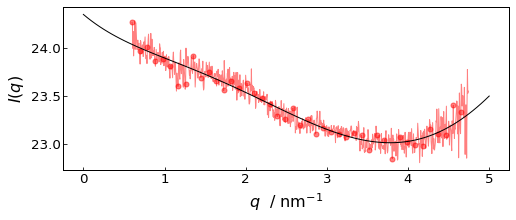

In [21]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 3], 'legend.fontsize': 'small',
                     'legend.frameon': False,'legend.labelspacing':0.2,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':'small','ytick.labelsize':'small',
                     'axes.labelsize':'medium','xtick.major.pad':3, 'ytick.major.pad':2})

a16 = plotWat('red',minq=120,maxq=1000)
print('2016 polynomial fit: ',a16)

### Guinier Analysis

Guinier Analysis for R10
('R_g', '\t\t\t', 'I(0)', '\t\t\t', 'conc')
('0.473', ' +/- ', '0.001', '\t', '5.17', ' +/- ', '0.01', '\t', '2.4', 'g/l')
('Calculated M_w of R10: ', '  62', '+/-', '   0')
('R10 - ratio calculated M_w / experimental M_w:', 0.039496565397858036)
('Relative Error:', 96.050343460214194, '%')
........................................................
Guinier Analysis for R8
('R_g', '\t\t\t', 'I(0)', '\t\t\t', 'conc')
('0.464', ' +/- ', '0.002', '\t', '4.65', ' +/- ', '0.01', '\t', '2.5', 'g/l')
('Calculated M_w of R8: ', '  54', '+/-', '   0')
('R8 - ratio calculated M_w / experimental M_w:', 0.034950744952695879)
('Relative Error:', 96.504925504730409, '%')
........................................................
Guinier Analysis for K10
('R_g', '\t\t\t', 'I(0)', '\t\t\t', 'conc')
('0.435', ' +/- ', '0.003', '\t', '3.45', ' +/- ', '0.01', '\t', '2.9', 'g/l')
('Calculated M_w of K10: ', '  34', '+/-', '   0')
('K10 - ratio calculated M_w / experimental M_w:', 0.025

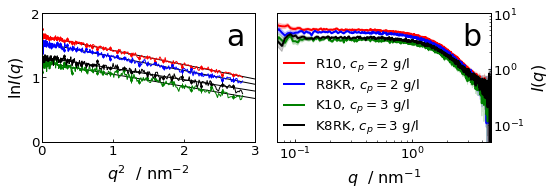

In [22]:
ax1 = plt.subplot(121)

plotGuinier('R10-300mM',data,ax1,pepdata,[0,1],corr=1,c='r')
plotGuinier('R8-300mM',data,ax1,pepdata,[0],corr=1,c='b')
plotGuinier('K10-300mM',data,ax1,pepdata,[0],corr=1,c='g')
plotGuinier('K8-300mM',data,ax1,pepdata,[1],corr=1,c='k')

plt.xlim(0,3)
plt.ylim(0,2)
plt.yticks(range(3))
plt.xticks(range(4))

#plt.legend(frameon=False,numpoints=1,loc='upper left')

ax2 = plt.subplot(122)

plotFF('R10-300mM',data,ax2,[0,1],corr=1,c='r')
plotFF('R8-300mM',data,ax2,[0],corr=1,c='b')
plotFF('K10-300mM',data,ax2,[0],corr=1,c='g')
plotFF('K8-300mM',data,ax2,[1],corr=1,c='k')

plt.ylim(0.05,10)
plt.xlim(0.07,4.7)

ax2.set_xscale("log")
ax2.set_yscale("log")

ax1.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax2.yaxis.tick_right()
ax2.xaxis.tick_bottom()

plt.figtext(0.41,0.74,'a',size=30)
plt.figtext(0.82,0.74,'b',size=30)

plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
ax2.yaxis.set_label_position("right")
plt.legend(frameon=False,numpoints=1,loc=(0.01,0.001),handlelength=1.5)
plt.tight_layout()
plt.savefig('fig/figS9.pdf')
plt.show()

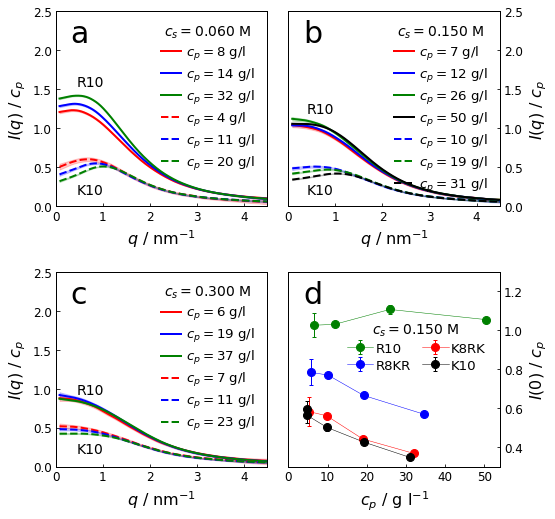

In [23]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 7.5], 'legend.fontsize': 'small',
                     'legend.frameon': False,'legend.labelspacing':0.3,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':'medium','xtick.major.pad':4, 'ytick.major.pad':4})

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False)

plotiq('R10-60mM',data,ax1,[0],corr=1.05,c='r')
plotiq('R10-60mM',data,ax1,[1],corr=1.05,c='b')
plotiq('R10-60mM',data,ax1,[3],c='g')

plotiq('K10-60mM',data,ax1,[0,1],c='r',ls='--')
plotiq('K10-60mM',data,ax1,[2],corr=1.05,c='b',ls='--')
plotiq('K10-60mM',data,ax1,[3],c='g',ls='--')

plotiq('R10-150mM',data,ax2,[0,1],c='r')
plotiq('R10-150mM',data,ax2,[2],c='b')
plotiq('R10-150mM',data,ax2,[3],1.05,c='g')
plotiq('R10-150mM',data,ax2,[4],1.05,c='k')

plotiq('K10-150mM',data,ax2,[2],corr=1.02,c='b',ls='--')
plotiq('K10-150mM',data,ax2,[3],c='g',ls='--')
plotiq('K10-150mM',data,ax2,[4],c='k',ls='--')

plotiq('R10-300mM',data,ax3,[0],c='r')
plotiq('R10-300mM',data,ax3,[3,4],c='b')
plotiq('R10-300mM',data,ax3,[5],c='g')

plotiq('K10-300mM',data,ax3,[0,1],c='r',ls='--')
plotiq('K10-300mM',data,ax3,[2],c='b',ls='--')
plotiq('K10-300mM',data,ax3,[3],c='g',ls='--')

#plotiq('K8-150mM',data,ax2,[2],c='b',ls='--')
#plotiq('K8-150mM',data,ax2,[3],c='g',ls='--')
#plotiq('K8-150mM',data,ax2,[4],c='k',ls='--')

ax1.set_xlabel(r'$q$ / nm$^{-1}$')
ax2.set_xlabel(r'$q$ / nm$^{-1}$')
ax3.set_xlabel(r'$q$ / nm$^{-1}$')

i0 = np.loadtxt('b2/i0_R10-150mM.dat',comments={'#','S','P'},usecols=(0,1,2))
i0[1,1] = .5 * ( i0[0,1] + i0[1,1] )
i0[1,2] = .5 * ( i0[0,1] - i0[1,1] )
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='g',lw=0.5,marker='o',
             markeredgecolor='g',alpha=1,label='R10',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_R8-150mM.dat',comments={'#','S','P'},usecols=(0,1,2))
i0[1,1] = .5 * ( i0[0,1] + i0[1,1] )
i0[1,2] = .5 * ( i0[0,1] - i0[1,1] )
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='b',lw=0.5,marker='o',
             markeredgecolor='b',alpha=1,label='R8KR',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_K8-150mM.dat',comments={'#','S','P'},usecols=(0,1,2))
i0[1,1] = .5 * ( i0[0,1] + i0[1,1] )
i0[1,2] = .5 * ( i0[0,1] - i0[1,1] )
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='r',lw=0.5,marker='o',
             markeredgecolor='r',alpha=1,label='K8RK',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_K10-150mM.dat',comments={'#','S','P'},usecols=(0,1,2))
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='k',lw=0.5,marker='o',
             markeredgecolor='k',alpha=1,label='K10',ms=8,elinewidth=1.,capsize=2,capthick=1.)

ax4.set_xlabel(r'$c_p$ / g l$^{-1}$')
ax4.set_ylabel(r'$I(0)$ / $c_p$')
ax4.set_xlim(0,54)
ax4.set_xticks(np.arange(0,55,10))
ax4.set_ylim(0.3,1.3)
ax4.legend(loc=(.25,.46),ncol=2,handletextpad=0.2,columnspacing=.8,title='$c_s=0.150$'+' M')
ax4.get_legend().get_title().set_fontsize('14')

plt.figtext(0.15,0.82,'R10',size=14)
plt.figtext(0.15,0.62,'K10',size=14)

plt.figtext(0.55,0.77,'R10',size=14)
plt.figtext(0.55,0.62,'K10',size=14)

plt.figtext(0.15,0.25,'R10',size=14)
plt.figtext(0.15,0.14,'K10',size=14)

ax1.yaxis.tick_left()
ax3.yaxis.tick_left()

ax1.annotate('a',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax3.annotate('c',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax4.annotate('d',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
f.tight_layout()
f.savefig('fig/fig1.pdf')
plt.show()

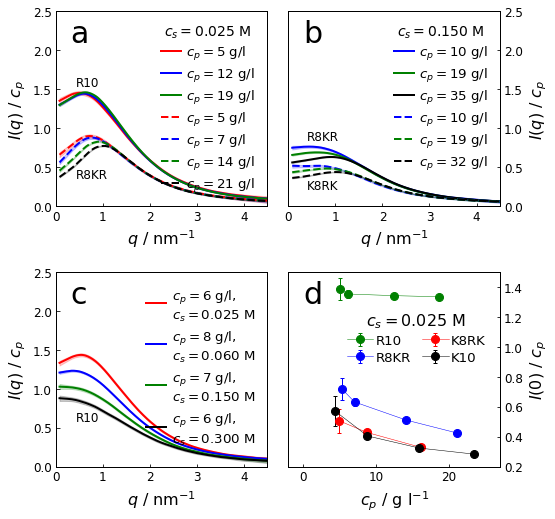

In [25]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 7.5], 
                     'savefig.dpi': 600, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.labelspacing':0.3,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':'medium','xtick.major.pad':4, 'ytick.major.pad':4})

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False)

plotiq('R10-25mM',data,ax1,[0,1],c='r')
#plotiq('R10-25mM',data,ax1,[2],c='b')
plotiq('R10-25mM',data,ax1,[3],c='b')
plotiq('R10-25mM',data,ax1,[4],c='g')

plotiq('R8-25mM',data,ax1,[0,1],c='r',ls='--')
plotiq('R8-25mM',data,ax1,[2],c='b',ls='--')
plotiq('R8-25mM',data,ax1,[3],c='g',ls='--')
plotiq('R8-25mM',data,ax1,[4],c='k',ls='--')

plotiq('R8-150mM',data,ax2,[2],c='b')
plotiq('R8-150mM',data,ax2,[3],1.02,c='g')
plotiq('R8-150mM',data,ax2,[4],1.02,c='k')

plotiq('K8-150mM',data,ax2,[2],1.05,c='b',ls='--')
plotiq('K8-150mM',data,ax2,[3],c='g',ls='--')
plotiq('K8-150mM',data,ax2,[4],c='k',ls='--')

plotiq_cs('R10-25mM',data,ax3,[2],c='r')
plotiq_cs('R10-60mM',data,ax3,[0],corr=1.05,c='b')
plotiq_cs('R10-150mM',data,ax3,[0,1],c='g')
plotiq_cs('R10-300mM',data,ax3,[0],c='k')

ax1.set_xlabel(r'$q$ / nm$^{-1}$')
ax2.set_xlabel(r'$q$ / nm$^{-1}$')
ax3.set_xlabel(r'$q$ / nm$^{-1}$')

i0 = np.loadtxt('b2/i0_R10-25mM.dat',comments={'#','S','P'},usecols=(0,1,2))
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='g',lw=0.5,marker='o',
             markeredgecolor='g',alpha=1,label='R10',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_R8-25mM.dat',comments={'#','S','P'},usecols=(0,1,2))
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='b',lw=0.5,marker='o',
             markeredgecolor='b',alpha=1,label='R8KR',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_K8-25mM.dat',comments={'#','S','P'},usecols=(0,1,2))
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='r',lw=0.5,marker='o',
             markeredgecolor='r',alpha=1,label='K8RK',ms=8,elinewidth=1.,capsize=2,capthick=1.)

i0 = np.loadtxt('b2/i0_K10-25mM.dat',comments={'#','S','P'},usecols=(0,1,2))
plt.errorbar(i0[:,0],i0[:,1],i0[:,2],color='k',lw=0.5,marker='o',
             markeredgecolor='k',alpha=1,label='K10',ms=8,elinewidth=1.,capsize=2,capthick=1.)

ax4.set_xlabel(r'$c_p$ / g l$^{-1}$')
ax4.set_ylabel(r'$I(0)$ / $c_p$')
ax4.set_xlim(-2,27)
ax4.set_ylim(.2,1.5)
ax4.legend(loc=(.25,.5),ncol=2,handletextpad=0.2,columnspacing=.8,title='$c_s=0.025$ M')

plt.figtext(0.15,0.82,'R10',size=12)
plt.figtext(0.15,0.65,'R8KR',size=12)
plt.figtext(0.55,0.72,'R8KR',size=12)
plt.figtext(0.55,0.63,'K8RK',size=12)
plt.figtext(0.15,0.20,'R10',size=12)

ax1.annotate('a',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax3.annotate('c',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)
ax4.annotate('d',xy=(0.07,0.84),xycoords='axes fraction',color='k',fontsize=30)

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig('fig/figS1.pdf')
plt.show()

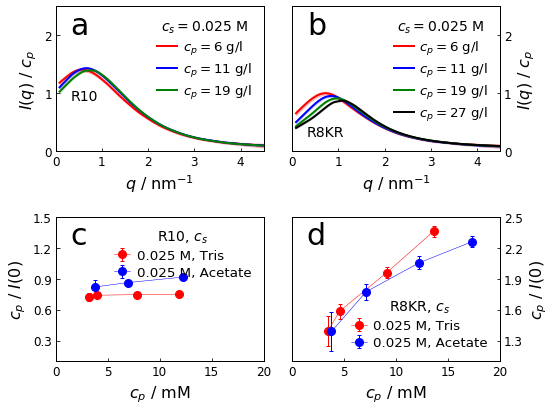

In [26]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 6], 
                     'savefig.dpi': 600, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.labelspacing':0.3,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':'medium','xtick.major.pad':4, 'ytick.major.pad':4})

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)

plotiq('R10-Ac-25mM',data,ax1,[0,1],c='r',corr=.95)
plotiq('R10-Ac-25mM',data,ax1,[2],c='b')
plotiq('R10-Ac-25mM',data,ax1,[3],c='g')

plotiq('R8-Ac-25mM',data,ax2,[0,1],c='r')
plotiq('R8-Ac-25mM',data,ax2,[2],c='b')
plotiq('R8-Ac-25mM',data,ax2,[3],c='g')
plotiq('R8-Ac-25mM',data,ax2,[4],c='k')

plotI0inv('R8-25mM',ax4,mw=1.552,c='r',l=', Tris')
plotI0inv('R8-Ac-25mM',ax4,mw=1.552,c='b',l=', Acetate')

plotI0inv('R10-25mM',ax3,mw=1.58,c='r',l=', Tris')
plotI0inv('R10-Ac-25mM',ax3,mw=1.58,c='b',l=', Acetate')

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax3.legend(title='R10, $c_s$',handlelength=1.2,handletextpad=0.5)
ax4.legend(title='R8KR, $c_s$',handlelength=1.2,handletextpad=0.5)
ax3.get_legend().get_title().set_fontsize('14')
ax4.get_legend().get_title().set_fontsize('14')
ax3.set_yticks([0.3,0.6,0.9,1.2,1.5])
ax4.set_yticks([1.3,1.6,1.9,2.2,2.5])
ax3.set_ylim(0.1,1.5)
ax4.set_ylim(1.1,2.5)

ax1.annotate('a',xy=(0.07,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.07,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax3.annotate('c',xy=(0.07,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax4.annotate('d',xy=(0.07,0.81),xycoords='axes fraction',color='k',fontsize=30)

ax3.set_xticks([0,5,10,15,20])
ax3.set_xlim(0,20)

ax4.set_xticks([0,5,10,15,20])
ax4.set_xlim(0,20)

ax1.set_xlabel(r'$q$ / nm$^{-1}$')
ax2.set_xlabel(r'$q$ / nm$^{-1}$')

ax1.annotate('R10',xy=(0.07,0.35),xycoords='axes fraction',color='k',fontsize=14)
ax2.annotate('R8KR',xy=(0.07,0.1),xycoords='axes fraction',color='k',fontsize=14)

ax1.set_yticks(range(3))
ax2.set_yticks(range(3))

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig('fig/figS2.pdf')
plt.show()

## HSQC NMR data

In [ ]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 8], 
                     'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.labelspacing':0.3,'axes.labelpad':5,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':'medium','xtick.major.pad':4, 'ytick.major.pad':4})

ax1 = plt.axes([.1, 0.45, .38, 0.52])
ax2 = plt.axes([.52, 0.45, .38, 0.52])
ax3 = plt.axes([.1, 0.08, .38, 0.27])
ax4 = plt.axes([.52, 0.08, .38, 0.27])

r10_30 = np.loadtxt('../nmr/r10_30mM.csv',comments={'#','S','P'},usecols=(0,1))
r10_5 = np.loadtxt('../nmr/r10_5mM.csv',comments={'#','S','P'},usecols=(0,1))
r10_1 = np.loadtxt('../nmr/r10_1mM.csv',comments={'#','S','P'},usecols=(0,1))

r8_5 = np.loadtxt('../nmr/r8_5mM.csv',comments={'#','S','P'},usecols=(0,1))
r8_20 = np.loadtxt('../nmr/r8_20mM.csv',comments={'#','S','P'},usecols=(0,1))

ax1.scatter(r10_30[:,0],r10_30[:,1],s=.1,c='g',marker='o',edgecolor='none',label='R10 30 mM')
ax1.scatter(r10_5[:,0],r10_5[:,1],s=.1,c='b',marker='o',edgecolor='none',label='R10 5 mM')
ax1.scatter(r10_1[:,0],r10_1[:,1],s=.1,c='r',marker='o',edgecolor='none',label='R10 1 mM')

ax1.invert_xaxis()
ax1.invert_yaxis()

ax2.scatter(r8_5[:,0],r8_5[:,1],s=.1,c='b',marker='o',edgecolor='none',label='R8KR 5 mM')
ax2.scatter(r8_20[:,0],r8_20[:,1],s=.1,c='g',marker='o',edgecolor='none',label='R8KR 20 mM')
ax2.invert_xaxis()
ax2.invert_yaxis()

ax1.set_xlabel(r'$\omega_2$ - $^1$H  / ppm')
ax1.set_ylabel(r'$\omega_1$ - $^{13}$C  / ppm')

ax2.set_xlabel(r'$\omega_2$ - $^1$H  / ppm')
ax2.set_ylabel(r'$\omega_1$ - $^{13}$C  / ppm')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

lr10_1 = mlines.Line2D([], [], color='r', label='$c_p=1$ mM')
lr10_5 = mlines.Line2D([], [], color='b', label='$c_p=5$ mM')
lr10_30 = mlines.Line2D([], [], color='g', label='$c_p=30$ mM')
lr8_5 = mlines.Line2D([], [], color='b', label='$c_p=5$ mM')
lr8_30 = mlines.Line2D([], [], color='g', label='$c_p=20$ mM')
ax1.legend(handles=[lr10_1,lr10_5,lr10_30],handlelength=1.2,framealpha=1,title='R10\n$c_s=0.025$ M',
                handletextpad=0.5,edgecolor='white',facecolor='white',loc='lower left',frameon=False)
ax2.legend(handles=[lr8_5,lr8_30],handlelength=1.2,handletextpad=0.5,framealpha=1,title='R8KR\n$c_s=0.025$ M',
               edgecolor='white',loc='lower left',frameon=False)
ax1.get_legend().get_title().set_fontsize('14')
ax2.get_legend().get_title().set_fontsize('14')
ax1.get_legend()._legend_box.align = "left"
ax2.get_legend()._legend_box.align = "left"
ax1.set_xlim(4.5,3.97)
ax2.set_xlim(4.5,3.97)
ax1.set_ylim(57.88,55.28)
ax2.set_ylim(57.88,55.28)
#ax1.set_yticks([58,57,56,55])
#ax2.set_yticks([58,57,56,55])
ax1.annotate('1',xy=(4.11,55.55),xycoords='data',color='k',fontsize=14)
ax1.annotate('10',xy=(4.15,57.49),xycoords='data',color='k',fontsize=14)
ax1.annotate('2',xy=(4.42,56.48),xycoords='data',color='k',fontsize=14)
ax1.annotate('3-9',xy=(4.25,56.3),xycoords='data',color='k',fontsize=14)
ax2.annotate('1',xy=(4.03,55.62),xycoords='data',color='k',fontsize=14)
ax2.annotate('10',xy=(4.14,57.68),xycoords='data',color='k',fontsize=14)
ax2.annotate('2',xy=(4.42,56.35),xycoords='data',color='k',fontsize=14)
ax2.annotate('9',xy=(4.23,56.8),xycoords='data',color='k',fontsize=14)
ax2.annotate('3-8',xy=(4.27,56.15),xycoords='data',color='k',fontsize=14)

plotI0inv('R8-25mM',ax4,mw=1.552,c='r')
#plotI0inv('R8-Ac-25mM',ax4,mw=1.552,c='y')
plotI0inv('R8-150mM',ax4,mw=1.552,c='b')
plotI0inv('R8-300mM',ax4,mw=1.552,c='g')

plotI0inv('R10-25mM',ax3,mw=1.58,c='r')
#plotI0inv('R10-Ac-25mM',ax3,mw=1.58,c='y')
plotI0inv('R10-60mM',ax3,mw=1.58,c='k')
plotI0inv('R10-150mM',ax3,mw=1.58,c='b')
plotI0inv('R10-300mM',ax3,mw=1.58,c='g')

circle=plt.Circle((4.35,57.6),.05,color='white',fill=True,lw=2)
ax1.add_artist(circle)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax3.legend(title='R10, $c_s$',handlelength=1.2,handletextpad=0.5,ncol=2)
ax4.legend(title='R8KR, $c_s$',handlelength=1.2,handletextpad=0.5)
ax3.get_legend().get_title().set_fontsize('14')
ax4.get_legend().get_title().set_fontsize('14')
ax3.set_yticks([0.3,0.6,0.9,1.2,1.5])
ax4.set_yticks([1.3,1.6,1.9,2.2,2.5])
ax3.set_ylim(0.1,1.6)
ax4.set_ylim(1.1,2.6)

ax3.get_legend()._legend_box.align = 'right'
ax4.get_legend()._legend_box.align = 'right'

ax1.annotate('a',xy=(0.07,0.9),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.07,0.9),xycoords='axes fraction',color='k',fontsize=30)
ax3.annotate('c',xy=(0.07,0.82),xycoords='axes fraction',color='k',fontsize=30)
ax4.annotate('d',xy=(0.07,0.82),xycoords='axes fraction',color='k',fontsize=30)

ax3.set_xticks([0,10,20,30])
ax3.set_xlim(0,35)

ax4.set_xticks([0,10,20,30])
ax4.set_xlim(0,35)

plt.savefig('../nmr/fig4.pdf')
plt.show()

# Potentials of Mean Force

In [3]:
%cd $workdir

# AMBER ff03W force field
windows_r10_0 = np.array([26,100,74,127,141,176,182,184,201,197,241,244,247,251,257,261,9,15,33,52,63])
windows_r10_60 = np.array([8,21,45,62,73,87,107,121,140,157,171,188,200,221])
windows_r10_300 = np.array([106,119,151,157,160,163,171,174,203,200,209,224,240,245,190,6,10,22,40])
windows_k10_0 = np.array([0,2,49,104,7,131,135,138,149,156,162,165,168,173,227,186,191,254])
windows_k10_60 = np.array([4,24,42,57,74,97,113,131,146,172,184,203])
windows_k10_300 = np.array([6,20,32,45,66,81,96,108,128,136,154,170,182,201])
# AMBER ff99SB-ILDN force field
windows_r10_60_108 = np.array([26, 323, 513, 869, 1069, 1447, 1667, 1990, 2272, 2480, 2678, 2960])
windows_r8_60_108 = np.array([1, 5, 18, 26, 30, 39, 45, 51, 59, 67, 72])
windows_r10_0_99 = np.array([26, 74, 100, 127, 141, 176, 182])
windows_r10_60_99 = np.array([8, 21, 30, 45, 62, 73, 87, 107, 121, 140, 157, 171, 188, 200, 221])
windows_r10_300_99 = np.array([106, 119, 151, 157, 160, 163, 171])
windows_r4_60_33 = np.array([1, 11, 17, 26, 35, 43, 51, 59, 66, 75])

# Debye-Hückel free energy
def DH(x,cs):
    lD = 0.304/np.sqrt(cs/1e3)
    return 8.3145*0.293*100*0.713/x*np.exp(-x/lD)

/Users/giulio/PNAS-resub/decaarginine


us = [{'sys':'r10_0','sims':windows_r10_0},
      {'sys':'r10_60','sims':windows_r10_60},
      {'sys':'r10_300','sims':windows_r10_300},
      {'sys':'k10_0','sims':windows_k10_0},
      {'sys':'k10_60','sims':windows_k10_60},
      {'sys':'k10_300','sims':windows_k10_300}
]

for sys in us:
    pep = sys['sys'].split('_')[0]
    cs = sys['sys'].split('_')[1]
    sims = sys['sims']
    c = np.empty(0)
    cerr = np.empty(0)
    x = np.empty(0)
    y = np.empty(0)
    xerr = np.empty(0)
    yerr = np.empty(0)
    ionic_strength = 1e10
    if (cs == '0'):
        ionic_strength = 14
    if (cs == '60'):
        ionic_strength = 71
    if (cs == '300'):
        ionic_strength = 315
    path = 'distances/'+cs+'mM/'+pep+'_99_a03/'
    for sim in sims:
        mean99 = np.loadtxt(path+str(sim)+'-99.dat',comments={'#','@'},usecols=(0,1))[:,1].mean()
        std99 = np.loadtxt(path+str(sim)+'-99.dat',comments={'#','@'},usecols=(0,1))[:,1].std()
        meanCom = np.loadtxt(path+str(sim)+'-com.dat',comments={'#','@'},usecols=(0,1))[:,1].mean()
        stdCom = np.loadtxt(path+str(sim)+'-com.dat',comments={'#','@'},usecols=(0,1))[:,1].std()
        x = np.append(x,mean99)
        xerr = np.append(xerr,std99)
        c = np.append(c,meanCom)
        cerr = np.append(cerr,stdCom)
    y = DH(c,ionic_strength)
    yerr = np.abs( DH(c+cerr,ionic_strength) - DH(c-cerr,ionic_strength) )
    dh = np.c_[x,y,xerr,yerr]
    avg = np.c_[x,c,y]
    std = np.c_[xerr,cerr,yerr]
    np.savetxt(path+'dh.dat',dh)
    np.savetxt(path+'avg.dat',avg)
    np.savetxt(path+'std.dat',std)
    
##################################################

us = [{'sys':'r10_60_99','sims':windows_r10_60_99},
      {'sys':'r10_60_108','sims':windows_r10_60_108},
      {'sys':'r8_60_108','sims':windows_r8_60_108}
]

for sys in us:
    pep = sys['sys'].split('_')[0]
    cs = sys['sys'].split('_')[1]
    rc = sys['sys'].split('_')[2]
    path = 'distances/'+cs+'mM/'+pep+'_'+rc+'_a99/'
    pathd = path + 'dist/'
    pathrc = path + 'rc/'
    ionic_strength = 1e10
    if (cs == '0'):
        ionic_strength = 14
    if (cs == '60'):
        ionic_strength = 71
    if (cs == '300'):
        ionic_strength = 315
    avg = np.empty(0)
    std = np.empty(0)
    dh = np.empty(0)
    d_cmcm = np.empty(0)
    for sim in sys['sims']:
        d99 = np.loadtxt(pathd+str(sim)+'-99.xvg',comments={'#','@'},usecols=(1))[500:]
        d108 = np.loadtxt(pathd+str(sim)+'-108.xvg',comments={'#','@'},usecols=(1))[500:]
        d810 = np.loadtxt(pathd+str(sim)+'-810.xvg',comments={'#','@'},usecols=(1))[500:]
        dcom = np.loadtxt(pathd+str(sim)+'-com.xvg',comments={'#','@'},usecols=(1))[500:]
        
        rcfile = glob.glob(pathrc+str(sim)+'-*.dat')[0]
        rc = np.loadtxt(rcfile,comments={'#','@'})
        if (rc[0,0] != 0):
            print(path,sim,rc[0,:])
            
        fdh = DH(dcom,ionic_strength)
    
        dh = np.append(dh,[rc[1000:,1].mean(),fdh.mean(),rc[1000:,1].std(),fdh.std()])
        avg = np.append(avg,[d99.mean(),d108.mean(),d810.mean(),dcom.mean(),fdh.mean()])
        std = np.append(std,[d99.std(),d108.std(),d810.std(),dcom.std(),fdh.std()])
               
    np.savetxt(path+'dh.dat',dh.reshape((int(sys['sims'].size),4)),fmt='%.3f')
    np.savetxt(path+'avg.dat',avg.reshape((int(sys['sims'].size),5)),fmt='%.3f')
    np.savetxt(path+'std.dat',std.reshape((int(sys['sims'].size),5)),fmt='%.3f')
    
##################################################

us = [{'sys':'r10_0_99','sims':windows_r10_0_99},
      {'sys':'r10_300_99','sims':windows_r10_300_99},
      {'sys':'r4_60_33','sims':windows_r4_60_33}
]

for sys in us:
    pep = sys['sys'].split('_')[0]
    cs = sys['sys'].split('_')[1]
    rc = sys['sys'].split('_')[2]
    path = 'distances/'+cs+'mM/'+pep+'_'+rc+'_a99/'
    pathd = path + 'dist/'
    ionic_strength = 1e10
    if (cs == '0'):
        ionic_strength = 14
    if (cs == '60'):
        ionic_strength = 68
    if (cs == '300'):
        ionic_strength = 315
    avg = np.empty(0)
    std = np.empty(0)
    dh = np.empty(0)
    d_cmcm = np.empty(0)
    for sim in sys['sims']:
        d = np.loadtxt(pathd+str(sim)+'-'+rc+'.xvg',comments={'#','@'},usecols=(1))[500:]
        dcom = np.loadtxt(pathd+str(sim)+'-com.xvg',comments={'#','@'},usecols=(1))[500:]
            
        fdh = DH(dcom,ionic_strength)
        if (pep == 'r4'):
            fdh = fdh*4*4/100.
    
        dh = np.append(dh,[d.mean(),fdh.mean(),d.std(),fdh.std()])
        avg = np.append(avg,[d.mean(),dcom.mean(),fdh.mean()])
        std = np.append(std,[d.std(),dcom.std(),fdh.std()])
               
    np.savetxt(path+'dh.dat',dh.reshape((int(sys['sims'].size),4)),fmt='%.3f')
    np.savetxt(path+'avg.dat',avg.reshape((int(sys['sims'].size),3)),fmt='%.3f')
    np.savetxt(path+'std.dat',std.reshape((int(sys['sims'].size),3)),fmt='%.3f')

In [4]:
r10_0 = np.loadtxt('distances/0mM/r10_99_a03/dh.dat')
r10_60 = np.loadtxt('distances/60mM/r10_99_a03/dh.dat')
r10_300 = np.loadtxt('distances/300mM/r10_99_a03/dh.dat')
k10_0 = np.loadtxt('distances/0mM/k10_99_a03/dh.dat')
k10_60 = np.loadtxt('distances/60mM/k10_99_a03/dh.dat')
k10_300 = np.loadtxt('distances/300mM/k10_99_a03/dh.dat')

In [5]:
# R10 9 -- 9, AMBER ff99SB-ILDN force field
pmf_r10_0_99_99 = np.loadtxt('pmfs/r10_0-99-99.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_r10_60_99_99 = np.loadtxt('pmfs/r10_60-99-99.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_r10_300_99_99 = np.loadtxt('pmfs/r10_300-99-99.xvg',comments={'#','@'},usecols=(0,1,2))
# R10 9 -- 9, AMBER ff03W force field
pmf_r10_0_99_03 = np.loadtxt('pmfs/r10_0-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_r10_60_99_03 = np.loadtxt('pmfs/r10_60-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_r10_300_99_03 = np.loadtxt('pmfs/r10_300-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
# K10 9 -- 9, AMBER ff03W force field
pmf_k10_0_99_03 = np.loadtxt('pmfs/k10_0-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_k10_60_99_03 = np.loadtxt('pmfs/k10_60-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
pmf_k10_300_99_03 = np.loadtxt('pmfs/k10_300-99-03.xvg',comments={'#','@'},usecols=(0,1,2))
# R4  3 -- 3, AMBER ff99SB-ILDN force field
pmf_r4_60_33_99 = np.loadtxt('pmfs/r4_60-33-99.xvg',comments={'#','@'},usecols=(0,1,2))
# R8KR 10 -- 8, AMBER ff99SB-ILDN force field
pmf_r8_60_108_99 = np.loadtxt('pmfs/r8_60-108-99.xvg',comments={'#','@'},usecols=(0,1,2))
# R10 10 -- 8, AMBER ff99SB-ILDN force field
pmf_r10_60_108_99 = np.loadtxt('pmfs/r10_60-108-99.xvg',comments={'#','@'},usecols=(0,1,2))
# R8KR 10 -- 2, AMBER ff99SB-ILDN force field
pmf_r8_60_102_99 = np.loadtxt('pmfs/r8_60-102-99.xvg',comments={'#','@'},usecols=(0,1,2))
# R10 10 -- 2, AMBER ff99SB-ILDN force field
pmf_r10_60_102_99 = np.loadtxt('pmfs/r10_60-102-99.xvg',comments={'#','@'},usecols=(0,1,2))

In [6]:
def DHscheme(x,y,q,cs):
    lD = 0.304/np.sqrt(cs/1e3)
    dhsum = np.empty(0)
    for i in range(x.size):
        x1 = np.delete(x,i) - x[i]
        y1 = np.delete(y,i) - y[i]
        qq = q[i]*np.delete(q,i)
        d = np.sqrt(x1*x1+y1*y1)
        dh = qq*0.713/d*np.exp(-d/lD)
        dhsum = np.append(dhsum,dh.sum())
    #print(dhsum.max(),dhsum.min())
    return dhsum

x = np.array([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11,9.5,10,11,12,13,14,15,16,17,18,19])
q = np.array([2])
q = np.append(q,np.full(shape=(9,1),fill_value=1))
q = np.append(q,[-1,-1])
q = np.append(q,np.full(shape=(9,1),fill_value=1))
q = np.append(q,2)
markers = np.array(['o','o','o','o','o','o','o','o','o','o','^','v','o','o','o','o','o','o','o','o','o','o'])

/Users/giulio/miniconda3/envs/python2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((9, 1), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


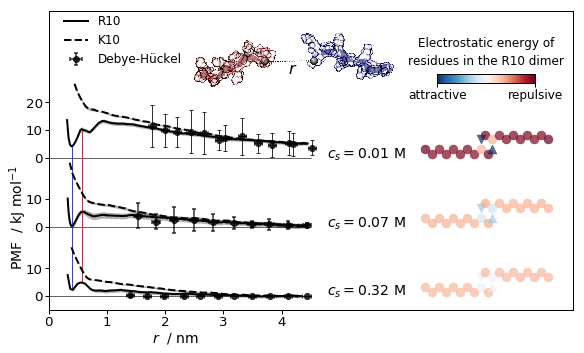

In [7]:
def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx
    
def plotPMF(array,c='black',w=0,a=0.3,l='',ls='-',shift=0,cs='0',pep='r10',rc='99',ff='a03'):
    path = 'distances/'+cs+'mM/'+pep+'_'+rc+'_'+ff+'/'
    dh = np.loadtxt(path+'dh.dat')
    # find index of largest distance
    maxdh = find_nearest(dh[:,0],4.4)
    maxd = find_nearest(array[:,0],dh[maxdh,0])
    # print(array[maxd,0],dh[maxdh,0])
    r = array[:maxd,0]
    pmf = array[:maxd,1]+8.3145*0.293*2*np.log(array[:maxd,0])
    pmf = pmf - pmf[-1] + dh[maxdh,1] + shift
    pmfl = pmf - array[:maxd,2]
    pmfu = pmf + array[:maxd,2]
    #minimum = find_nearest(r,.4)
    #print(path,pmf[minimum]-shift)
    #print(path,pmfl[minimum]-shift)
    #print(path,pmfu[minimum]-shift)
    #print(path,r[minimum])
    plt.fill_between(r,pmfl,pmfu,alpha=a,color=c,lw=0)
    plt.plot(r,pmf,color=c,lw=w,label=l,linestyle=ls)

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 5], 
                     'savefig.dpi': 600, 'legend.fontsize': 12, 'legend.frameon': False,
                     'legend.numpoints':1,'xtick.direction':'out','ytick.direction':'out',
                     'axes.linewidth':1.,'xtick.labelsize':'small',
                     'ytick.labelsize':'small','axes.labelsize':'medium',
                     'xtick.major.pad':2, 'ytick.major.pad':2})

fig = plt.figure()

ax3 = plt.axes([.635, .13, .33, 0.83])
yticks = np.arange(-2, 26,5)
xticks = np.arange(0,5,1)
ax3.patch.set_alpha(0)

plt.xlim(-3.5,23.5)
plt.ylim(-10,120)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.patch.set_alpha(0)
plt.xticks([])
plt.yticks([])
ax3.spines['left'].set_color('white')
ax3.spines['right'].set_color('white')
ax3.spines['top'].set_color('white')
ax3.spines['bottom'].set_color('white')

y = np.append(np.tile([1,.93],5),[1,1.14])
y = np.append(y,np.tile([1.21,1.14],5))*30

vmin = DHscheme(x*3,y/10,q,0.5).min()
vmax = DHscheme(x*3,y/10,q,0.01).max()

cmap = cm.RdBu_r

y = y - 30
for xx, yy, dh, mm in zip(x, y, DHscheme(x*3,y/10,q,302), markers):
    plt.scatter(xx+3,yy,c=dh, cmap=cmap,s=80,lw=0.5,vmin=vmin,vmax=vmax,alpha=0.7,marker=mm)
    
y = y + 30
for xx, yy, dh, mm in zip(x, y, DHscheme(x*3,y/10,q,57), markers):
    plt.scatter(xx+3,yy,c=dh, cmap=cmap,s=80,lw=0.5,vmin=vmin,vmax=vmax,alpha=0.7,marker=mm)
    
y = y + 30
for xx, yy, dh, mm in zip(x, y, DHscheme(x*3,y/10,q,0.0001), markers):
    plt.scatter(xx+3,yy,c=dh, cmap=cmap,s=80,lw=0.5,vmin=vmin,vmax=vmax,alpha=0.7,marker=mm)
    
ax4 = plt.axes([.755, .76, .17, .1])
plt.xticks([])
plt.yticks([])
ax4.spines['bottom'].set_color('white')
ax4.spines['top'].set_color('white') 
ax4.spines['right'].set_color('white')
ax4.spines['left'].set_color('white')
ax4.patch.set_alpha(0)
cbar_ax = fig.add_axes([.755, .76, .17, .025])
cb = colorbar(cax=cbar_ax, orientation='horizontal',drawedges=False)
cb.set_label('Electrostatic energy of\nresidues in the R10 dimer',size=12,labelpad=-65,linespacing=1.5)
cb.set_ticks((vmin,vmax))
cb.set_ticklabels(['attractive','repulsive'])
cb.ax.tick_params(axis='both', length=4, width=1.,labelsize=12)

ax2 = plt.axes([.33, .65, .35, .35])
img=mpimg.imread('fig/dimerk10.png')
ax2.imshow(img)
plt.xticks([])
plt.yticks([])
ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white') 
ax2.spines['right'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.patch.set_alpha(0)

ax1 = plt.axes([.08, .13, .91, 0.83])
yticks = np.arange(-10,98,10)
xticks = np.arange(0,5,1)
plt.xlim(0,9)
plt.ylim(-10,98)
plt.xticks(xticks)
plt.yticks(yticks)
ax1.patch.set_alpha(0)

plt.axhline(y=-5,xmin=0,xmax=.5,color='black',lw=.6)
plt.axhline(y=20,xmin=0,xmax=.5,color='black',lw=.6)
plt.axhline(y=45,xmin=0,xmax=.5,color='black',lw=.6)

plt.axvline(x=.4,ymin=.07,ymax=.55,color='#3f43ad',lw=1)
plt.axvline(x=.58,ymin=.09,ymax=.6,color='#ac3e42',lw=1)

plotPMF(pmf_r10_0_99_03,'black',w=2,l='R10',ls='-',shift=45,cs='0',pep='k10',rc='99',ff='a03')
plotPMF(pmf_k10_0_99_03,'black',w=2,l='K10',ls='--',shift=45,cs='0',pep='k10',rc='99',ff='a03')

plotPMF(pmf_r10_60_99_03,'black',w=2,ls='-',shift=20,cs='60',pep='k10',rc='99',ff='a03')
plotPMF(pmf_k10_60_99_03,'black',w=2,ls='--',shift=20,cs='60',pep='k10',rc='99',ff='a03')

plotPMF(pmf_r10_300_99_03,'black',w=2,ls='-',shift=-5,cs='300',pep='r10',rc='99',ff='a03')
plotPMF(pmf_k10_300_99_03,'black',w=2,ls='--',shift=-5,cs='300',pep='k10',rc='99',ff='a03')

labels = ['0', '10', '0', '10','0','10','20']
plt.yticks([-5,5,20,30,45,55,65],labels)

plt.errorbar(r10_0[6:-2,0],r10_0[6:-2,1]+45,r10_0[6:-2,3],r10_0[6:-2,2],color='black',lw=0,marker='o',
             markeredgecolor=None,alpha=0.8,markersize=6,elinewidth=1.,capsize=2,capthick=1.)

plt.errorbar(r10_60[3:-1,0],r10_60[3:-1,1]+20,r10_60[3:-1,3],r10_60[3:-1,2],color='black',lw=0,marker='o',
             markeredgecolor=None,alpha=0.8,markersize=6,elinewidth=1.5,capsize=2,capthick=1.5,label=u'Debye-Hückel')

plt.errorbar(k10_300[3:,0],k10_300[3:,1]-5,k10_300[3:,3],k10_300[3:,2],color='black',lw=0,marker='o',
             markeredgecolor=None,alpha=0.8,markersize=6,elinewidth=1.,capsize=2,capthick=1.)

plt.legend(frameon=False,loc=(0.02,0.8))

plt.figtext(0.495,0.785,'$r$',size=16)

plt.figtext(0.7,0.17,'$c_s=$0.32 M',size=14,ha='right')

plt.figtext(0.7,0.36,'$c_s=$0.07 M',size=14,ha='right')

plt.figtext(0.7,0.55,'$c_s=$0.01 M',size=14,ha='right')

plt.figtext(0.008,0.49,'PMF  / kJ mol$^{-1}$', size=14, rotation='vertical')

plt.figtext(0.26,0.04,'$r$  / nm', size=14)

ax1.tick_params('both', length=4, width=1., which='major')
ax3.tick_params('both', length=4, width=1., which='major')

ax1.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax3.yaxis.tick_right()
ax3.xaxis.tick_bottom()

plt.savefig('fig/fig2.pdf')

plt.show()

(2.024867, 1.8260000000000001)
(1.9690920000000001, 1.7736265154331272)
(2.4306220000000001, 2.2280000000000002)
(2.3639459999999999, 2.1597576177822178)
(2.2020240000000002, 2.0099999999999998)
(2.2706590000000002, 2.0636419264277555)
(2.4306220000000001, 2.2280000000000002)
(2.5795780000000001, 2.3820000000000001)


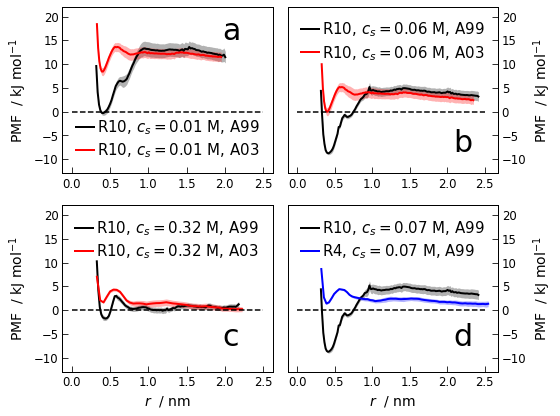

In [33]:
plt.rcParams.update({'font.size': 14, 'figure.figsize': [8.0, 6],'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.major.size':6, 'ytick.major.size':6, 'xtick.direction':'in','ytick.direction':'in'})

def plotPMF(array,subplot,rmax,c='black',w=0,a=0.3,l='',shift=0,ls='-',cs='0',pep='r10',rc='99',ff='a03'):
    path = 'distances/'+cs+'mM/'+pep+'_'+rc+'_'+ff+'/'
    dh = np.loadtxt(path+'dh.dat')
    # find index of largest distance
    maxdh = find_nearest(dh[:,0],rmax)
    maxd = find_nearest(array[:,0],dh[maxdh,0]+.2)
    r = array[:maxd,0]
    print(array[maxd,0],dh[maxdh,0])
    pmf = array[:maxd,1]+8.3145*0.293*2*np.log(array[:maxd,0])
    pmf = pmf - pmf[-1] + dh[maxdh,1] + shift
    pmfl = pmf - array[:maxd,2]
    pmfu = pmf + array[:maxd,2]
    subplot.fill_between(r,pmfl,pmfu,alpha=a,color=c,lw=0)
    subplot.plot(r,pmf,color=c,lw=w,label=l,linestyle=ls)
    subplot.set_ylabel('PMF  / kJ mol$^{-1}$')
    subplot.legend(loc='best',handlelength=1.2,frameon=False,fontsize=15,handletextpad=0.2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

plotPMF(pmf_r10_0_99_99,ax1,rmax=2,c='k',w=2,l='R10, $c_s=0.01$ M, A99',cs='0',pep='r10',rc='99',ff='a99')
plotPMF(pmf_r10_60_99_03,ax1,rmax=1.8,c='r',w=2,l='R10, $c_s=0.01$ M, A03',cs='0',pep='r10',rc='99',ff='a03')
ax1.plot( [0,2.5], [0,0], 'k--')

plotPMF(pmf_r10_60_99_99,ax2,rmax=2.1,c='k',w=2,l='R10, $c_s=0.06$ M, A99',cs='60',pep='r10',rc='99',ff='a99')
plotPMF(pmf_r10_60_99_03,ax2,rmax=2,c='r',w=2,l='R10, $c_s=0.06$ M, A03',cs='60',pep='r10',rc='99',ff='a03')
ax2.plot( [0,2.5], [0,0], 'k--')

plotPMF(pmf_r10_300_99_99,ax3,rmax=1.9,c='k',w=2,l='R10, $c_s=0.32$ M, A99',cs='300',pep='r10',rc='99',ff='a99')
plotPMF(pmf_r10_300_99_03,ax3,rmax=2,c='r',w=2,l='R10, $c_s=0.32$ M, A03',cs='300',pep='r10',rc='99',ff='a03')
ax3.set_xlabel('$r$  / nm')
ax3.plot( [0,2.5], [0,0], 'k--')

plotPMF(pmf_r10_60_99_99,ax4,rmax=2.2,c='k',w=2,l='R10, $c_s=0.07$ M, A99',cs='60',pep='r10',rc='99',ff='a99')
plotPMF(pmf_r4_60_33_99,ax4,rmax=2.3,c='b',w=2,l='R4, $c_s=0.07$ M, A99',cs='60',pep='r4',rc='33',ff='a99')
ax4.set_xlabel('$r$  / nm')
ax4.plot( [0,2.5], [0,0], 'k--')

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

ax1.set_ylim(-13,22)
ax2.set_ylim(-13,22)
ax3.set_ylim(-13,22)
ax4.set_ylim(-13,22)

plt.figtext(0.40,0.89,'a',size=30)
plt.figtext(0.80,0.63,'b',size=30)
plt.figtext(0.40,0.18,'c',size=30)
plt.figtext(0.80,0.18,'d',size=30)

ax1.yaxis.tick_left()
ax3.yaxis.tick_left()

f.tight_layout()
f.savefig('fig/figS3.pdf')
plt.show()

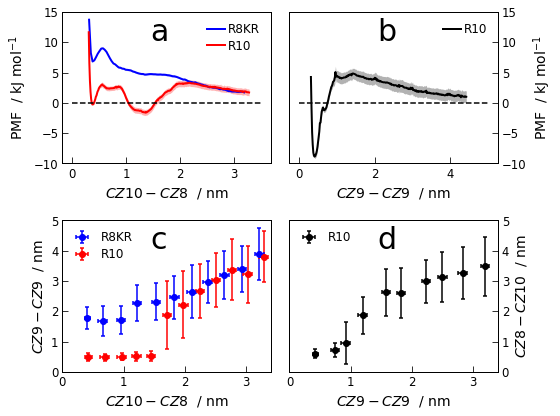

In [34]:
plt.rcParams.update({'font.size': 14, 'figure.figsize': [8.0, 6],'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.major.size':6, 'ytick.major.size':6, 'xtick.direction':'in','ytick.direction':'in'})
    
def plotPMF(array,subplot,c='black',w=0,a=0.3,l='',shift=0,ls='-',cs='0',pep='r10',rc='99',ff='a03'):
    path = 'distances/'+cs+'mM/'+pep+'_'+rc+'_'+ff+'/'
    dh = np.loadtxt(path+'dh.dat')
    # find index of largest distance
    maxdh = find_nearest(dh[:,0],4.4)
    maxd = find_nearest(array[:,0],dh[maxdh,0])
    r = array[:maxd,0]
    pmf = array[:maxd,1]+8.3145*0.293*2*np.log(array[:maxd,0])
    pmf = pmf - pmf[-1] + dh[maxdh,1] + shift
    pmfl = pmf - array[:maxd,2]
    pmfu = pmf + array[:maxd,2]
    subplot.fill_between(r,pmfl,pmfu,alpha=a,color=c,lw=0)
    subplot.plot(r,pmf,color=c,lw=w,label=l,linestyle=ls)
    subplot.set_ylabel('PMF  / kJ mol$^{-1}$')
    subplot.legend(loc='upper right',handlelength=1.5,frameon=False,handletextpad=0.2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False)

plotPMF(pmf_r8_60_108_99,ax1,c='b',w=2,l='R8KR',cs='60',pep='r8',rc='108',ff='a99')
plotPMF(pmf_r10_60_108_99,ax1,c='r',w=2,l='R10',cs='60',pep='r10',rc='108',ff='a99')

ax1.set_xlabel('$CZ10-CZ8$  / nm')
ax1.plot( [0,3.5], [0,0], 'k--')

plotPMF(pmf_r10_60_99_99,ax2,c='k',w=2,l='R10',cs='60',pep='r10',rc='99',ff='a99')

ax2.set_xlabel('$CZ9-CZ9$  / nm')
ax2.plot( [0,5], [0,0], 'k--')

path = '/Users/giulio/Dropbox/ecis/distances/60mM/'

avg = np.loadtxt(path + 'r8_108_a99/avg.dat')
std = np.loadtxt(path + 'r8_108_a99/std.dat')

ax3.errorbar(avg[:,1],avg[:,0],xerr=std[:,1],yerr=std[:,0],lw=0,marker='o',color='b',
         markeredgecolor='b',ms=6,elinewidth=1.5,capsize=2,capthick=1.5,label='R8KR')
    
avg = np.loadtxt(path + 'r10_108_a99/avg.dat')
std = np.loadtxt(path + 'r10_108_a99/std.dat')

ax3.errorbar(avg[:,1],avg[:,0],xerr=std[:,1],yerr=std[:,0],lw=0,marker='o',color='r',
         markeredgecolor='r',ms=6,elinewidth=1.5,capsize=2,capthick=1.5,label='R10')

ax3.set_xlabel('$CZ10-CZ8$  / nm')
ax3.set_xlim(0,3.4)

avg = np.loadtxt(path + 'r10_99_a99/avg.dat')
std = np.loadtxt(path + 'r10_99_a99/std.dat')

ax4.errorbar(avg[:,0],avg[:,2],xerr=std[:,0],yerr=std[:,2],lw=0,marker='o',color='k',
         markeredgecolor='k',ms=6,elinewidth=1.5,capsize=2,capthick=1.5,label='R10')
ax4.set_xlabel('$CZ9-CZ9$  / nm')
ax4.set_xlim(0,3.4)

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

ax1.set_ylim(-10,15)
ax2.set_ylim(-10,15)
ax3.set_ylim(0,5)
ax4.set_ylim(0,5)

ax3.legend(loc='upper left',handlelength=1.5,frameon=False,numpoints=1)
ax4.legend(loc='upper left',handlelength=1.5,frameon=False,numpoints=1)

ax3.set_ylabel('$CZ9-CZ9$  / nm')
ax4.set_ylabel('$CZ8-CZ10$  / nm')

ax1.yaxis.tick_left()
ax3.yaxis.tick_left()

ax1.annotate('a',xy=(0.42,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.42,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax3.annotate('c',xy=(0.42,0.81),xycoords='axes fraction',color='k',fontsize=30)
ax4.annotate('d',xy=(0.42,0.81),xycoords='axes fraction',color='k',fontsize=30)

f.tight_layout()
f.savefig('fig/figS5.pdf')
plt.show()

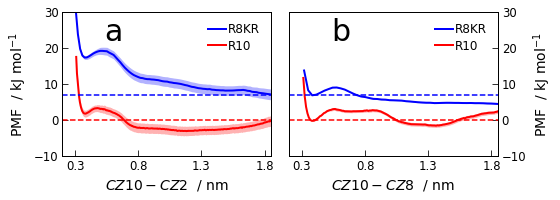

In [35]:
plt.rcParams.update({'font.size': 14, 'figure.figsize': [8.0, 3],'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.major.size':6, 'ytick.major.size':6, 'xtick.direction':'in','ytick.direction':'in'})

f, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False)

plotPMF(pmf_r8_60_102_99,ax1,c='b',w=2,shift=6,l='R8KR',cs='60',pep='r8',rc='108',ff='a99')
plotPMF(pmf_r10_60_102_99,ax1,c='r',w=2,shift=11,l='R10',cs='60',pep='r8',rc='108',ff='a99')
plotPMF(pmf_r8_60_108_99,ax2,c='b',w=2,l='R8KR',cs='60',pep='r8',rc='108',ff='a99')
plotPMF(pmf_r10_60_108_99,ax2,c='r',w=2,l='R10',cs='60',pep='r10',rc='108',ff='a99')

ax1.set_xlim(0.2,1.85)
ax2.set_xlim(0.2,1.85)
ax1.set_ylim(-10,30)
ax2.set_ylim(-10,30)

ax1.plot( [0.2,1.85], [0,0], 'r--')
ax2.plot( [0.2,1.85], [0,0], 'r--')
ax1.plot( [0.2,1.85], [7,7], 'b--')
ax2.plot( [0.2,1.85], [7,7], 'b--')

ax1.set_xlabel('$CZ10-CZ2$  / nm')
ax2.set_xlabel('$CZ10-CZ8$  / nm')

ax1.yaxis.tick_left()

ax1.annotate('a',xy=(0.2,0.8),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.2,0.8),xycoords='axes fraction',color='k',fontsize=30)

ax1.set_xticks(np.arange(.3,1.9,.5))
ax2.set_xticks(np.arange(.3,1.9,.5))

ax1.set_yticks(np.arange(-10,31,10))
ax2.set_yticks(np.arange(-10,31,10))

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

f.tight_layout()
f.savefig('fig/figS6.pdf')
plt.show()

## PDB analysis

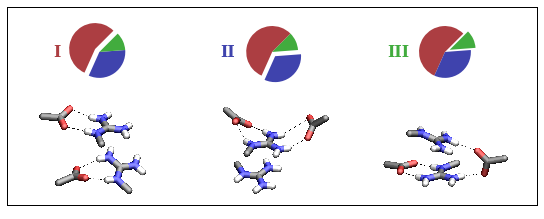

In [36]:
plt.rcParams.update({'font.size': 13, 'figure.figsize': [8.0, 3], 
                     'savefig.dpi': 300, 'axes.linewidth':1., 'font.family':'DejaVu Serif'})

fig = plt.figure()

labels = 'I', 'II', 'III'
fracs = [55.8, 32.9, 11.3]
c = ['#ac3e42','#3f43ad','#42ac3e']

ax2 = plt.axes([.05, .6, .3, .3])
explode=(0.2, 0, 0)
ax2.set_aspect('equal')
ax2.pie(fracs, explode=explode, colors = c,textprops={'weight': 'bold','fontsize':'15'},
                shadow=False, startangle=45,wedgeprops = { 'linewidth' : 0 })

ax2 = plt.axes([.35, .6, .3, .3])
explode=(0, 0.2, 0)
ax2.set_aspect('equal')
ax2.pie(fracs, explode=explode, colors = c,textprops={'weight': 'bold','fontsize':'15'},
                shadow=False, startangle=45,wedgeprops = { 'linewidth' : 0 })

ax2 = plt.axes([.65, .6, .3, .3])
explode=(0, 0, 0.2)
ax2.set_aspect('equal')
ax2.pie(fracs, explode=explode, colors = c,textprops={'weight': 'bold','fontsize':'15'},
                shadow=False, startangle=45,wedgeprops = { 'linewidth' : 0 })


plt.xticks([])
plt.yticks([])
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.patch.set_alpha(0)

ax1 = plt.axes([-.06, .045, .5, .5])
img=mpimg.imread('fig/4JL5_1.png')
ax1.imshow(img)
plt.xticks([])
plt.yticks([])
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.patch.set_alpha(0)
    
ax1 = plt.axes([.25, .045, .5, .5])
img=mpimg.imread('fig/4GGD_2.png')
ax1.imshow(img)
plt.xticks([])
plt.yticks([])
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.patch.set_alpha(0)
    
ax1 = plt.axes([.55, .01, .5, .5])
img=mpimg.imread('fig/4GDX_1.png')
ax1.imshow(img)
plt.xticks([])
plt.yticks([])
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.patch.set_alpha(0)

plt.figtext(0.12,0.73,'I',size='large',color='#ac3e42',weight='demibold',multialignment='left')
plt.figtext(0.41,0.73,'II',size='large',color='#3f43ad',weight='demibold',multialignment='right')
plt.figtext(0.7,0.73,'III',size='large',color='#42ac3e',weight='demibold',multialignment='right')

ax0 = plt.axes([.04, .04, .92, 0.92])
plt.xticks([])
plt.yticks([])
ax0.patch.set_alpha(0)

ax1.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax3.yaxis.tick_right()
ax3.xaxis.tick_bottom()

#plt.axvline(x=1/6,ymin=.04,ymax=.92,color='black',lw=1)
#plt.axvline(x=3/6,ymin=.04,ymax=.92,color='black',lw=1)
#plt.axvline(x=5/6,ymin=.04,ymax=.92,color='red',lw=1)

plt.savefig('fig/fig5.pdf')

plt.show()

In [37]:
%cd $workdir

r10_cz = np.array([209,452]).reshape(1,2)

trl99 = md.load('r10lstckd/r10lstckd_99.xtc', top='r10lstckd/r10lstckd.pdb')
hbrl99 = md.wernet_nilsson(trl99[:], periodic=False)
czrl99 = md.compute_distances(trl99, r10_cz)

trm99 = md.load('r10mstckd/r10mstckd_99.xtc', top='r10mstckd/r10mstckd_99.pdb')
hbrm99 = md.wernet_nilsson(trm99[:],periodic=False)
czrm99 = md.compute_distances(trm99, r10_cz)

trh99 = md.load('r10hstckd/r10hstckd_99.xtc', top='r10hstckd/r10hstckd_99.pdb')
hbrh99 = md.wernet_nilsson(trh99[:],periodic=False)
czrh99 = md.compute_distances(trh99, r10_cz)

trl = md.load('r10lstckd/r10lstckd.xtc', top='r10lstckd/r10lstckd.pdb')
hbrl = md.wernet_nilsson(trl[:],periodic=False)
czrl = md.compute_distances(trl, r10_cz)

trm = md.load('r10mstckd/r10mstckd.xtc', top='r10mstckd/r10mstckd.pdb')
hbrm = md.wernet_nilsson(trm[:],periodic=False)
czrm = md.compute_distances(trm, r10_cz)

trh = md.load('r10hstckd/r10hstckd.xtc', top='r10hstckd/r10hstckd.pdb')
hbrh = md.wernet_nilsson(trh[:],periodic=False)
czrh = md.compute_distances(trh, r10_cz)

k10_ce = np.array([191,414]).reshape(1,2)

tkh = md.load('k10hstckd/k10hstckd.xtc', top='k10hstckd/k10hstckd.pdb')
hbkh = md.wernet_nilsson(tkh[:],periodic=False)
cekh = md.compute_distances(tkh, k10_ce)

tkm = md.load('k10mstckd/k10mstckd.xtc', top='k10mstckd/k10mstckd.pdb')
hbkm = md.wernet_nilsson(tkm[:],periodic=False)
cekm = md.compute_distances(tkm, k10_ce)

tkl = md.load('k10lstckd/k10lstckd.xtc', top='k10lstckd/k10lstckd.pdb')
hbkl = md.wernet_nilsson(tkl[:],periodic=False)
cekl = md.compute_distances(tkl, k10_ce)

/Users/giulio/PNAS-resub/SI-data


/Users/giulio/miniconda3/envs/python2/lib/python2.7/site-packages/mdtraj/geometry/hbond.py:166: RuntimeWarning: invalid value encountered in less
  mask = np.logical_and(distances < cutoffs, angles < angle_cutoff)


## Hydrogen bond probabilities - AMBER ff03WS

(11559, 4251, 11602, 11801, 2251, 7001)
(10.0, 40.0, 19740.0, 10.0, 40.0, 10.0)
ARG10-O
ARG10-OXT
ARG10-O
ARG10-OXT
('max', 0.84797975390522728, 0.99735003613587092, 0.52521300643366375)
('min', 0.0, 0.0, 0.0)
LYS10-O
LYS10-OXT
LYS20-O
LYS20-OXT
('max', 0.20459789761558841, 0.22733612273361228, 0.20113027097522099)
('min', 0.0, 0.0, 0.0)


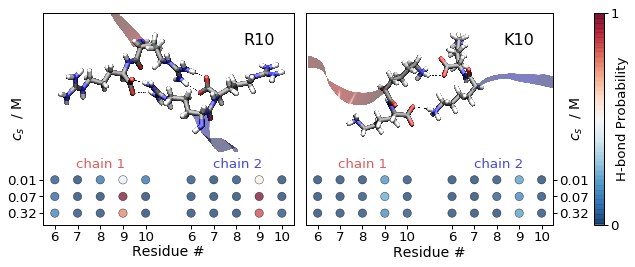

In [38]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.7, 3.5], 'font.family':'DejaVu Sans',
                     'savefig.dpi': 600, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.numpoints':1,'xtick.direction':'out','ytick.direction':'out',
                     'axes.linewidth':1.,'xtick.labelsize':'small','ytick.labelsize':'small',
                     'axes.labelsize':14,'xtick.major.pad':2, 'ytick.major.pad':2})

print(trh.n_frames,trm.n_frames,trl.n_frames,tkh.n_frames,tkm.n_frames,tkl.n_frames)
print(trh.timestep,trm.timestep,trl.timestep,tkh.timestep,tkm.timestep,tkl.timestep)
fig = plt.figure()
from pylab import cm,clabel,colorbar

for i in [241,242,484,485]:
    print(trh.topology.atom(i))

def Phb(t,hb,cz):
    tot = np.zeros(11)
    w_tot = 0
    hb = np.array(hb)
    cz = np.array(cz)
    for i,d in zip(hb[100:],cz[100:]):
        frame = np.zeros(11)
        weight = 1 #np.exp(500./.293/8.3145*.5*(cz[0][0]-d)**2)
        for j in i:
            if((j[2]==484 or j[2]==485) and (5 <= t.topology.atom(j[0]).residue.index < 10)):
                if (frame[t.topology.atom(j[0]).residue.index-5]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-5]+=weight
            if((j[2]==241 or j[2]==242) and (15 <= t.topology.atom(j[0]).residue.index < 20)):
                if (frame[t.topology.atom(j[0]).residue.index-9]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-9]+=weight
        tot = tot + frame
        w_tot += weight
    return tot/w_tot

a = Phb(trh,hbrh,czrh)
b = Phb(trm,hbrm,czrm)
c = Phb(trl,hbrl,czrl)
print('max',a.max(),b.max(),c.max())
print('min',a.min(),b.min(),c.min())
z = [None]*(len(a)+len(b)+len(c))
z[::3] = a
z[1::3] = b
z[2::3] = c
x = np.repeat(np.arange(1,12,1),3)
y = np.tile(np.arange(1,4,1),11)

ax0 = plt.axes([-.015, .42, .55,.55])
img=mpimg.imread('fig/r10l_hbonds.png')
ax0.imshow(img)
plt.xticks([])
plt.yticks([])
xticks = np.arange(0,6,1)
ax0.spines['bottom'].set_color('white')
ax0.spines['top'].set_color('white') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

ax3 = plt.axes([0.445, .45, .465, .465])
img=mpimg.imread('fig/k10l_hbonds.png')
ax3.imshow(img)
plt.xticks([])
plt.yticks([])
xticks = np.arange(0,6,1)
ax3.spines['bottom'].set_color('white')
ax3.spines['top'].set_color('white') 
ax3.spines['right'].set_color('white')
ax3.spines['left'].set_color('white')

ax1 = plt.axes([.06, .13, .40, 0.84])
sc = plt.scatter(x,y,c=z,cmap=cm.RdBu_r,s=70,lw=0.5,vmin=0,vmax=1,alpha=0.7,edgecolors='k')
labels = ['6', '7', '8', '9','10','6', '7', '8', '9','10']
plt.xticks([1,2,3,4,5,7,8,9,10,11],labels)
labels = ['0.32','0.07','0.01']
plt.yticks(np.arange(1,4,1),labels)
plt.ylim(0.3,13)
plt.xlabel('Residue #',labelpad=1,fontsize=14)
plt.ylabel('$c_s$  / M',labelpad=-20)
ax1.patch.set_alpha(0)
ax1.tick_params('y', length=4, width=1, which='major')
ax1.tick_params('x', length=4, width=1, which='major')

for i in [221,222,444,445]:
    print(tkh.topology.atom(i))

def Phb(t,hb,ce):
    tot = np.zeros(11)
    w_tot = 0
    hb = np.array(hb)
    ce = np.array(ce)
    for i,d in zip(hb[100:],ce[100:]):
        frame = np.zeros(11)
        weight = 1 #np.exp(500./.293/8.3145*.5*(ce[0][0]-d)**2)
        for j in i:
            if((j[2]==444 or j[2]==445) and (5 <= t.topology.atom(j[0]).residue.index < 10)):
                if (frame[t.topology.atom(j[0]).residue.index-5]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-5]+=weight
            if((j[2]==221 or j[2]==222) and (15 <= t.topology.atom(j[0]).residue.index < 20)):
                if (frame[t.topology.atom(j[0]).residue.index-9]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-9]+=weight
        tot = tot + frame
        w_tot += weight
    return tot/w_tot

a = Phb(tkh,hbkh,cekh)
b = Phb(tkm,hbkm,cekm)
c = Phb(tkl,hbkl,cekl)
print('max',a.max(),b.max(),c.max())
print('min',a.min(),b.min(),c.min())
z = [None]*(len(a)+len(b)+len(c))
z[::3] = a
z[1::3] = b
z[2::3] = c
x = np.repeat(np.arange(1,12,1),3)
y = np.tile(np.arange(1,4,1),11)

ax2 = plt.axes([.48, .13, .54, 0.84])

sc = plt.scatter(x,y,c=z, cmap=cm.RdBu_r,s=70,lw=0.5,vmin=0,vmax=1,alpha=0.7,edgecolors='k')
labels = ['6', '7', '8', '9','10','6', '7', '8', '9','10']
plt.xticks([1,2,3,4,5,7,8,9,10,11],labels)
labels = ['0.32','0.07','0.01']
ax2.yaxis.tick_right() 
plt.yticks(np.arange(1,4,1),labels)
ax2.yaxis.set_label_position("right")
plt.ylim(0.3,13)
plt.xlabel('Residue #',labelpad=2,fontsize=14)
plt.ylabel('$c_s$  / M',labelpad=-20)
cb = colorbar(sc,pad=0.12)
cb.set_label('H-bond Probability',size='small',labelpad=-3)
cb.set_ticks((0,1))
cb.ax.tick_params(axis='both', length=4, width=1.)
ax2.patch.set_alpha(0)
ax2.tick_params('y', length=4, width=1, which='major')
ax2.tick_params('x', length=4, width=1, which='major')

ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()

ax1.add_patch(mpl.patches.Rectangle((5.7,0),0.6,3.6,color='white'))
ax2.add_patch(mpl.patches.Rectangle((5.7,0),0.6,3.6,color='white'))

ax1.annotate('R10',xy=(0.8,0.85),xycoords='axes fraction',color='k',fontsize='medium')
ax2.annotate('K10',xy=(0.8,0.85),xycoords='axes fraction',color='k',fontsize='medium')

ax1.annotate('chain 1',xy=(0.13,0.27),xycoords='axes fraction',color='#de5c5c',fontsize='small')
ax2.annotate('chain 1',xy=(0.13,0.27),xycoords='axes fraction',color='#de5c5c',fontsize='small')
ax1.annotate('chain 2',xy=(0.68,0.27),xycoords='axes fraction',color='#4949d3',fontsize='small')
ax2.annotate('chain 2',xy=(0.68,0.27),xycoords='axes fraction',color='#4949d3',fontsize='small')

plt.savefig('fig/fig3.pdf')

## Hydrogen bond probabilities - AMBER ff99SB-ILDN

(11559, 4251, 11602, 11801, 2251, 7001)
(10.0, 40.0, 19740.0, 10.0, 40.0, 10.0)
ARG10-O
ARG10-OXT
ARG10-O
ARG10-OXT
('max', 1.0, 0.99950641658440276, 0.9965449160908193)
('min', 0.0, 0.0, 0.0)
('Average CZ9-CZ9:', 0.42199999999999999, '+/-', 0.040000000000000001, 'nm')


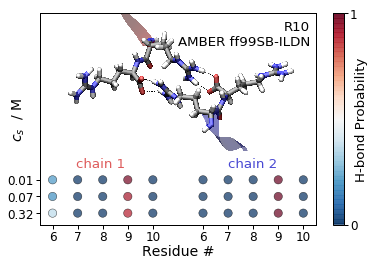

In [39]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6, 3.5], 
                     'savefig.dpi': 600, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.numpoints':1,'xtick.direction':'out','ytick.direction':'out',
                     'axes.linewidth':1.,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':14,'xtick.major.pad':2, 'ytick.major.pad':2})

print(trh.n_frames,trm.n_frames,trl.n_frames,tkh.n_frames,tkm.n_frames,tkl.n_frames)
print(trh.timestep,trm.timestep,trl.timestep,tkh.timestep,tkm.timestep,tkl.timestep)
fig = plt.figure()
from pylab import cm,clabel,colorbar

for i in [241,242,484,485]:
    print(trh.topology.atom(i))

def Phb(t,hb,cz):
    tot = np.zeros(11)
    w_tot = 0
    hb = np.array(hb)
    cz = np.array(cz)
    for i,d in zip(hb[100:],cz[100:]):
        frame = np.zeros(11)
        weight = 1 #np.exp(500./.293/8.3145*.5*(cz[0][0]-d)**2)
        for j in i:
            if((j[2]==484 or j[2]==485) and (5 <= t.topology.atom(j[0]).residue.index < 10)):
                if (frame[t.topology.atom(j[0]).residue.index-5]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-5]+=weight
            if((j[2]==241 or j[2]==242) and (15 <= t.topology.atom(j[0]).residue.index < 20)):
                if (frame[t.topology.atom(j[0]).residue.index-9]<1):
                    #print(t.topology.atom(j[0]))
                    frame[t.topology.atom(j[0]).residue.index-9]+=weight
        tot = tot + frame
        w_tot += weight
    return tot/w_tot

a = Phb(trh99,hbrh99,czrh99)
b = Phb(trm99,hbrm99,czrm99)
c = Phb(trl99,hbrl99,czrl99)
print('max',a.max(),b.max(),c.max())
print('min',a.min(),b.min(),c.min())
z = [None]*(len(a)+len(b)+len(c))
z[::3] = a
z[1::3] = b
z[2::3] = c
x = np.repeat(np.arange(1,12,1),3)
y = np.tile(np.arange(1,4,1),11)

ax0 = plt.axes([0.15, .378, .64,.64])
img=mpimg.imread('fig/r10l_hbonds.png')
ax0.imshow(img)
plt.xticks([])
plt.yticks([])
xticks = np.arange(0,6,1)
ax0.spines['bottom'].set_color('white')
ax0.spines['top'].set_color('white') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

ax1 = plt.axes([.15, .13, .8, 0.84])
sc = plt.scatter(x,y,c=z,cmap=cm.RdBu_r,s=70,lw=0.5,vmin=0,vmax=1,alpha=0.7,edgecolors='k')
labels = ['6', '7', '8', '9','10','6', '7', '8', '9','10']
plt.xticks([1,2,3,4,5,7,8,9,10,11],labels)
labels = ['0.32','0.07','0.01']
plt.yticks(np.arange(1,4,1),labels)
plt.ylim(0.3,13)
plt.xlabel('Residue #',labelpad=1,fontsize=14)
plt.ylabel('$c_s$  / M',labelpad=-20)
ax1.patch.set_alpha(0)
ax1.tick_params('y', length=4, width=1, which='major')
ax1.tick_params('x', length=4, width=1, which='major')


cb = colorbar(sc)
cb.set_label('H-bond Probability',size='small',labelpad=-3)
cb.set_ticks((0,1))
cb.ax.tick_params(axis='both', length=4, width=1.)

ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax1.add_patch(mpl.patches.Rectangle((5.7,0),0.6,3.6,color='white'))

ax1.annotate('R10\nAMBER ff99SB-ILDN',xy=(0.5,0.85),xycoords='axes fraction',color='k',
             fontsize='small',multialignment='right')
ax1.annotate('chain 1',xy=(0.13,0.27),xycoords='axes fraction',color='#de5c5c',fontsize='small')
ax1.annotate('chain 2',xy=(0.68,0.27),xycoords='axes fraction',color='#4949d3',fontsize='small')

plt.savefig('fig/figS4.pdf')

r10_60_99_rc = np.loadtxt('distances/60mM/r10_99_a99/dh.dat',usecols=(0,2))
print('Average CZ9-CZ9:',r10_60_99_rc[0,0],'+/-',r10_60_99_rc[0,1],'nm')

## Relative orientation of peptides at close separation

(ARG1-CA, ARG10-C, array([[247, 483]], dtype=int32))
('Number of frames: ', 11601, '... timestep: ', 10.0)
('Volume: ', '1215.32', ' nm^3')
('Ionic Strength: ', '13.66', ' mM')
('c_s: ', '0.00', ' mM')
------------------------
(ARG1-CA, ARG10-C, array([[247, 483]], dtype=int32))
('Number of frames: ', 4251, '... timestep: ', 40.0)
('Volume: ', '1220.08', ' nm^3')
('Ionic Strength: ', '70.77', ' mM')
('c_s: ', '57.16', ' mM')
------------------------
(ARG1-CA, ARG10-C, array([[247, 483]], dtype=int32))
('Number of frames: ', 11559, '... timestep: ', 10.0)
('Volume: ', '1206.31', ' nm^3')
('Ionic Strength: ', '315.24', ' mM')
('c_s: ', '301.47', ' mM')
------------------------
(LYS11-CA, LYS20-C, array([[227, 443]], dtype=int32))
('Number of frames: ', 7001, '... timestep: ', 10.0)
('Volume: ', '1202.25', ' nm^3')
('Ionic Strength: ', '13.81', ' mM')
('c_s: ', '0.00', ' mM')
------------------------
(LYS11-CA, LYS20-C, array([[227, 443]], dtype=int32))
('Number of frames: ', 2251, '... t

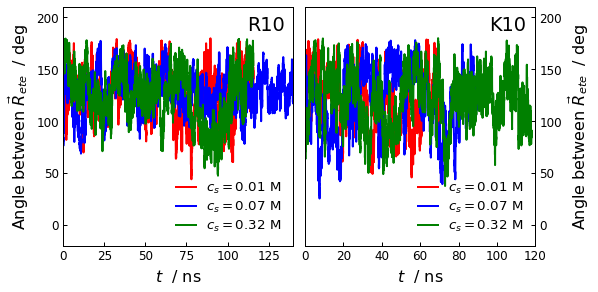

In [40]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 4],'font.family':'DejaVu Sans',
                     'savefig.dpi': 300, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.numpoints':1,'xtick.direction':'in','ytick.direction':'in',
                     'axes.linewidth':1.0,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':'medium','xtick.major.pad':4, 'ytick.major.pad':4})

def angle(t,s1='index 4',s2='index 240',s3='index 247',s4='index 483',c='blue',l=''):
    ends1 = t.topology.select_pairs(selection1=s1, selection2=s2)
    ends2 = t.topology.select_pairs(selection1=s3, selection2=s4)
    ete1 = md.compute_displacements(t,ends1)
    ete2 = md.compute_displacements(t,ends2)
    print(t.topology.atom(ends2[0][0]), t.topology.atom(ends2[0][1]), ends2)
    ions = t.topology.select('name CL or name NA')
    na = t.topology.select('name NA')
    vol = 0.707*(t.unitcell_lengths.mean())**3
    print('Number of frames: ',t.n_frames,'... timestep: ',t.timestep)
    print('Volume: ','{:1.2f}'.format(vol),' nm^3')
    Is = len(ions)/6.022/vol*1e4/2
    cs = len(na)/6.022/vol*1e4
    print('Ionic Strength: ','{:1.2f}'.format(Is),' mM') 
    print('c_s: ','{:1.2f}'.format(cs),' mM')
    print('------------------------')
    def angle_between(v1, v2):
        def unit_vector(vector):
            return vector / np.linalg.norm(vector)
        array = np.empty((0,1))
        for i in np.arange(0,v1.shape[0],1):
            v1_u = unit_vector(v1[i][0])
            v2_u = unit_vector(v2[i][0])
            array = np.append(array,[[np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi*180]],axis=0)
        return array
    plt.plot(np.arange(0,t.n_frames,1)*t.timestep*1e-3,angle_between(ete1,ete2),color=c,label=l,lw=2)
    plt.xlabel('$t$  / ns')
    plt.ylim(-20,210)
    plt.ylabel(r'Angle between $\vec R_{ete}$  / deg')
    
ax1 = plt.axes([.09, .13, .4, 0.83])
angle(trl[1:],c='red',l='$c_s=0.01$ M')
angle(trm,c='blue',l='$c_s=0.07$ M')
angle(trh,c='green',l='$c_s=0.32$ M')
plt.legend(frameon=False,loc='lower right',handlelength=1.5)
plt.xlim(0,140)

ax2 = plt.axes([.51, .13, .4, 0.83])
angle(tkl,s1='index 4',s2='index 220',s3='index 227',s4='index 443',c='red',l='$c_s=0.01$ M')
angle(tkm,s1='index 4',s2='index 220',s3='index 227',s4='index 443',c='blue',l='$c_s=0.07$ M')
angle(tkh,s1='index 4',s2='index 220',s3='index 227',s4='index 443',c='green',l='$c_s=0.32$ M')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.xlim(0,120)

ax1.tick_params('both', length=4, width=1., which='major')
ax2.tick_params('both', length=4, width=1., which='major')

ax1.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax2.yaxis.tick_right()
ax2.xaxis.tick_bottom()

ax1.annotate('R10',xy=(0.8,0.9),xycoords='axes fraction',color='k',fontsize='large')
ax2.annotate('K10',xy=(0.8,0.9),xycoords='axes fraction',color='k',fontsize='large')

plt.legend(frameon=False,loc='lower right',handlelength=1.5)
plt.savefig('fig/figS10.pdf')
plt.show()

## Coordination with Chloride Ions

(66, 0.52644487944516272, 6, 16, 0.505)
(79, 0.71667802875692199, 7, 19, 0.505)
(88, 0.41040573336861352, 8, 18, 0.505)
(93, 0.64364071325822314, 9, 13, 0.505)
(96, 0.57156181877309631, 9, 16, 0.505)


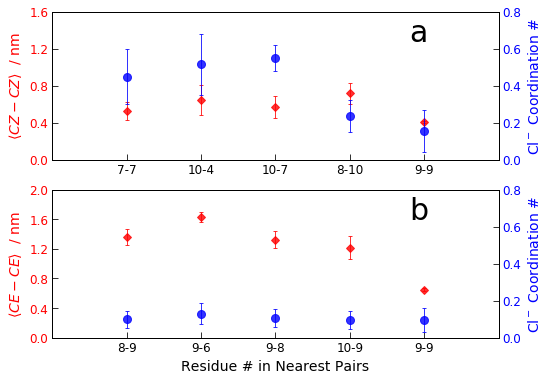

In [41]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8, 6], 
                     'savefig.dpi': 600, 'legend.fontsize': 'small', 'legend.frameon': False,
                     'legend.numpoints':1, 'axes.linewidth':1.0,
                     'axes.linewidth':1.,'xtick.labelsize':12,'ytick.labelsize':12,
                     'axes.labelsize':14, 'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.direction':'in','ytick.direction':'in'})
def rhocl(t):
    vol = 0.707*(t.unitcell_lengths.mean())**3
    return len(t.topology.select('name CL'))/vol

f, (ax1,ax3) = plt.subplots(2, 1, sharex=False, sharey=False)

rr = [.2,1]
uplim = int(1e2*(.5-rr[0]))

for t in [trm]:
    rho_cl = rhocl(t)
    n_fr = int(t.n_frames/10.)
    dist = np.empty(0)
    dist_err = np.empty(0)
    cnum = np.empty(0)
    cnum_err = np.empty(0)
    cnt = 0
    for res1 in range(0,10):
        cz1 = t.topology.select('resid '+str(res1)+' and name CZ')
        for res2 in range(10,20):
            cz2 = t.topology.select('resid '+str(res2)+' and name CZ')
            pairs = t.topology.select_pairs(t.topology.select('name CL'),np.append(cz1,cz2))
            czcz = t.top.select_pairs(cz1,cz2)
            cnum_fr = np.empty(0)
            dist_fr = np.empty(0)
            for i in np.arange(0,t.n_frames,n_fr,dtype=int):
                r,gr = md.compute_rdf(t[i:i+n_fr],pairs,r_range=rr,bin_width=0.01)
                cnum_fr = np.append(cnum_fr,rho_cl*np.trapz(gr[:uplim]*4.*np.pi*r[:uplim]*r[:uplim],r[:uplim]))
                dist_fr = np.append(dist_fr,md.compute_distances(t[i:i+n_fr], czcz).mean())
            cnum = np.append(cnum,np.average(cnum_fr))
            cnum_err = np.append(cnum_err,np.std(cnum_fr))
            dist = np.append(dist,np.average(dist_fr))
            dist_err = np.append(dist_err,np.std(dist_fr))
            if (cnt in [66,93,96,79,88]):
                print(cnt,np.average(dist_fr),res1,res2,r[uplim])
            cnt += 1
    dist_stkd = np.array([dist[66],dist[93],dist[96],dist[79],dist[88]])
    cnum_stkd = np.array([cnum[66],cnum[93],cnum[96],cnum[79],cnum[88]])
    dist_stkd_err = np.array([dist_err[66],dist_err[93],dist_err[96],dist_err[79],dist_err[88]])
    cnum_stkd_err = np.array([cnum_err[66],cnum_err[93],cnum_err[96],cnum_err[79],cnum_err[88]])
    ax1.errorbar(range(0,5),dist_stkd,dist_stkd_err,color='r',lw=0,marker='D',
             markeredgecolor='r',alpha=0.8,markersize=6,elinewidth=1.,capsize=2,capthick=1.)
    #ax1.set_xlabel('residue #')
    ax1.set_ylabel(r'$\langle CZ-CZ \rangle$  / nm', color='r')
    ax1.set_ylim(0,1.6)
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax2 = ax1.twinx()
    ax2.set_ylim(0,.8)
    ax2.errorbar(range(0,5),cnum_stkd,cnum_stkd_err,color='b',lw=0,marker='o',
             markeredgecolor='b',alpha=0.8,markersize=8,elinewidth=1.,capsize=2,capthick=1.)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Cl$^-$ Coordination #', color='b')
    for tl in ax2.get_yticklabels():
        tl.set_color('b')
    labels = ['7-7','10-4','10-7','8-10','9-9']
    plt.xticks(range(0,5),labels)
    ax1.set_yticks(np.arange(0,1.7,.4))
    ax2.set_yticks(np.arange(0,.9,.2))
    plt.xlim(-1,5)

for t in [tkl]:
    rho_cl = rhocl(t)
    n_fr = int(t.n_frames/10.)
    dist = np.empty(0)
    dist_err = np.empty(0)
    cnum = np.empty(0)
    cnum_err = np.empty(0)
    cnt = 0
    for res1 in range(0,10):
        ce1 = t.topology.select('resid '+str(res1)+' and name CE')
        for res2 in range(10,20):
            ce2 = t.topology.select('resid '+str(res2)+' and name CE')
            pairs = t.topology.select_pairs(t.topology.select('name CL'),np.append(ce1,ce2))
            cece = t.top.select_pairs(ce1,ce2)
            cnum_fr = np.empty(0)
            dist_fr = np.empty(0)
            for i in np.arange(0,t.n_frames,n_fr,dtype=int):
                r,gr = md.compute_rdf(t[i:i+n_fr],pairs,r_range=rr,bin_width=0.01)
                cnum_fr = np.append(cnum_fr,rho_cl*np.trapz(gr[:uplim]*4.*np.pi*r[:uplim]*r[:uplim],r[:uplim]))
                dist_fr = np.append(dist_fr,md.compute_distances(t[i:i+n_fr], cece).mean())
            cnum = np.append(cnum,np.average(cnum_fr))
            cnum_err = np.append(cnum_err,np.std(cnum_fr))
            dist = np.append(dist,np.average(dist_fr))
            dist_err = np.append(dist_err,np.std(dist_fr))
            #print(cnt,np.average(dist_fr),res1,res2,r[uplim])
            cnt += 1
    dist_stkd = np.array([dist[78],dist[85],dist[87],dist[98],dist[88]])
    cnum_stkd = np.array([cnum[78],cnum[85],cnum[87],cnum[98],cnum[88]])
    dist_stkd_err = np.array([dist_err[78],dist_err[85],dist_err[87],dist_err[98],dist_err[88]])
    cnum_stkd_err = np.array([cnum_err[78],cnum_err[85],cnum_err[87],cnum_err[98],cnum_err[88]])
    ax3.errorbar(range(0,5),dist_stkd,dist_stkd_err,color='r',lw=0,marker='D',
             markeredgecolor='r',alpha=0.8,markersize=6,elinewidth=1.,capsize=2,capthick=1.)
    ax3.set_xlabel('Residue # in Nearest Pairs')
    ax3.set_ylabel(r'$\langle CE-CE \rangle$  / nm', color='r')
    ax3.set_ylim(0,2)
    for tl in ax3.get_yticklabels():
        tl.set_color('r')
    ax4 = ax3.twinx()
    ax4.set_ylim(0,.8)
    ax4.errorbar(range(0,5),cnum_stkd,cnum_stkd_err,color='b',lw=0,marker='o',
             markeredgecolor='b',alpha=0.8,markersize=8,elinewidth=1.,capsize=2,capthick=1.)
    ax4.yaxis.set_label_position("right")
    ax4.set_ylabel('Cl$^-$ Coordination #', color='b')
    for tl in ax4.get_yticklabels():
        tl.set_color('b')
    labels = ['8-9','9-6','9-8','10-9','9-9']
    plt.xticks(range(0,5),labels)
    ax3.set_yticks(np.arange(0,2.1,.4))
    ax4.set_yticks(np.arange(0,.9,.2))
    plt.xlim(-1,5)
    ax1.annotate('a',xy=(0.8,0.8),xycoords='axes fraction',color='k',fontsize=30)
    ax3.annotate('b',xy=(0.8,0.8),xycoords='axes fraction',color='k',fontsize=30)
plt.savefig('fig/figS8.pdf')
plt.show()

## PMFs $vs.$ c.o.m.-c.o.m.

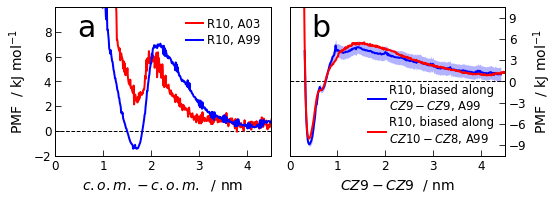

In [42]:
plt.rcParams.update({'font.size': 14, 'figure.figsize': [8.0, 3], 'font.family':'DejaVu Sans',
                     'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.major.size':6, 'ytick.major.size':6, 'xtick.direction':'in','ytick.direction':'in'})

f, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False)

ax1.plot( [0,4.5], [0,0], 'k--', lw=1)
ax2.plot( [0,4.5], [0,0], 'k--', lw=1)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_99_a03/dist/'
r,pmf = np.loadtxt(path+'pmfy-com.dat',unpack=True)
idx = find_nearest(r,4.5)
ax1.plot(r,(pmf-pmf[idx])*.293*8.3145+DH(r[idx],71),lw=2,color='r',label='R10, A03')
path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/dist/'
r,pmf = np.loadtxt(path+'pmfy-com.dat',unpack=True)
idx = find_nearest(r,4.5)
ax1.plot(r,(pmf-pmf[idx])*.293*8.3145+DH(r[idx],71),lw=2,color='b',label='R10, A99')

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/dist/'
r,pmf = np.loadtxt(path+'pmfy-99.dat',unpack=True)
plotPMF(pmf_r10_60_99_99,ax2,'b',2,ls='-',cs='60',pep='r10',rc='99',ff='a99',l='R10, biased along\n$CZ9-CZ9$, A99')
ax2.plot(r,pmf*.293*8.3145-63,lw=2,color='r',label='R10, biased along\n$CZ10-CZ8$, A99')

ax1.set_xlim(0,4.5)
ax2.set_xlim(0,4.5)
ax1.set_ylim(-2,10)
ax2.set_ylim(-10.5,10.5)

ax1.set_xlabel('$c.o.m.-c.o.m.$  / nm')
ax2.set_xlabel('$CZ9-CZ9$  / nm')
ax1.set_ylabel('PMF  / kJ mol$^{-1}$')
ax2.set_ylabel('PMF  / kJ mol$^{-1}$')

ax1.yaxis.tick_left()

ax1.annotate('a',xy=(0.1,0.8),xycoords='axes fraction',color='k',fontsize=30)
ax2.annotate('b',xy=(0.1,0.8),xycoords='axes fraction',color='k',fontsize=30)

ax1.set_xticks(np.arange(0,5,1))
ax2.set_xticks(np.arange(0,5,1))

ax1.set_yticks(np.arange(-2,10,2))
ax2.set_yticks(np.arange(-9,11,3))

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.legend(loc='upper right',handlelength=1.5,frameon=False,handletextpad=0.3)
ax2.legend(loc='lower right',handlelength=1.5,frameon=False,handletextpad=0.3)

f.tight_layout()
f.savefig('fig/figS7.pdf')
plt.show()

## Estimate of $K_D$ - AMBER ff03WS

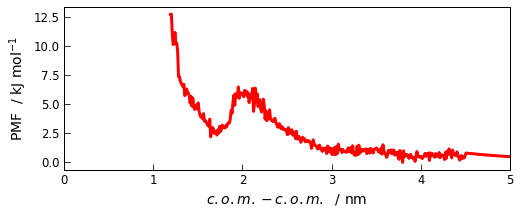

('R10, AMBER ff03W, Kd = 338', ' mM')


In [27]:
path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_99_a03/dist/'
r,pmf = np.loadtxt(path+'pmfy-com.dat',unpack=True)
idx = find_nearest(r,4.5)
x = np.arange(r[idx+1],100,r[1]-r[0])
pmf = np.append((pmf[:idx]-pmf[idx])*.293*8.3145+DH(r[idx],71), DH(x,71))
r = np.append(r[:idx],x)
noninf = pmf.size - np.where(~np.isinf(pmf))[0].size
pmf = pmf[noninf:]
r = r[noninf:]
plt.plot(r,pmf,lw=3,color='r',label='R10, A03')
plt.xlim(0,5)
plt.xlabel('$c.o.m.-c.o.m.$  / nm')
plt.ylabel('PMF  / kJ mol$^{-1}$')
plt.show()

RT=8.3145*.293
idx = find_nearest(r,2)
int1 = np.trapz(r[:idx]*r[:idx]*np.exp(-pmf[:idx]/RT),r[:idx])
int2 = np.trapz(r[idx+1:]*r[idx+1:]*np.exp(-pmf[idx+1:]/RT),r[idx+1:])
Kd = int2/int1/(4/3.*np.pi*np.power(r[-1],3))/6.022*10000
print('R10, AMBER ff03W, Kd = {:1.0f}'.format(Kd),' mM')

## Estimate of $K_D$ - AMBER ff99SB-ILDN

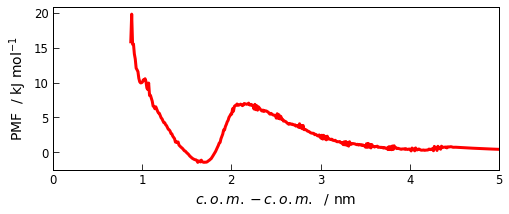

('R10, AMBER ff99SB-ILDN, Kd = 69', ' mM')


In [28]:
path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/dist/'
r,pmf = np.loadtxt(path+'pmfy-com.dat',unpack=True)
idx = find_nearest(r,4.5)
x = np.arange(r[idx+1],100,r[1]-r[0])
pmf = np.append((pmf[:idx]-pmf[idx])*.293*8.3145+DH(r[idx],71), DH(x,71))
r = np.append(r[:idx],x)
noninf = pmf.size - np.where(~np.isinf(pmf))[0].size
pmf = pmf[noninf:]
r = r[noninf:]
plt.plot(r,pmf,lw=3,color='r',label='R10, A03')
plt.xlim(0,5)
plt.xlabel('$c.o.m.-c.o.m.$  / nm')
plt.ylabel('PMF  / kJ mol$^{-1}$')
plt.show()

RT=8.3145*.293
idx = find_nearest(r,2.2)
int1 = np.trapz(r[:idx]*r[:idx]*np.exp(-pmf[:idx]/RT),r[:idx])
int2 = np.trapz(r[idx+1:]*r[idx+1:]*np.exp(-pmf[idx+1:]/RT),r[idx+1:])
Kd = int2/int1/(4/3.*np.pi*np.power(r[-1],3))/6.022*10000
print('R10, AMBER ff99SB-ILDN, Kd = {:1.0f}'.format(Kd),' mM')

### Calculate PMF using WHAM

#### B. Roux. The calculation of the potential of mean force using computer
#### simulations. Computer Physics Communications 91, 275 (1995). 

#### D. Minh. Multidimensional Potentials of Mean Force from Biased
#### Experiments Along a Single Coordinate. Journal of Physical 
#### Chemistry B 111(16), 4137-4140 (2007). 

def wham(sims,path,ab_name,framestart=-90000, temperature=293):
    RT = 8.3145*temperature/1000      # energy unit, (kJ/mol)
    ks = 500.              # bias spring constant, (kJ/mol/nm^2)
    numsims = sims.size
        
    xmax = np.loadtxt(path+str(sims.max())+ab_name+'.dat',comments={'#','@'},usecols=(1)).max()

    xedges = np.arange(0,xmax,0.01)
    xvalues = xedges[:-1]+(xedges[1]-xedges[0])*0.5
    xnumbins = xedges.size-1
    Ubiases = np.zeros((numsims,xnumbins))
    Hx = np.zeros((numsims,xnumbins))
    
    for n,sim in enumerate(sims): 
        x = np.loadtxt(path+str(sim)+ab_name+'.dat',comments={'#','@'},usecols=(0,1))
        center = x[0,1]
        print('First Frame at Time:',x[framestart,0])
        x = x[framestart:,1]
        hx,xedges = np.histogram(x,bins=xedges,normed=True)
        Hx[n] = hx
        Ubiases[n] = 0.5*ks*np.power(center-xvalues,2)
        plt.plot(xvalues,hx)
    plt.ylabel('$P(r)$')
    plt.xlabel('$r$  / nm')
    plt.show()

    #### WHAM variables
    Fx = np.zeros((numsims,))   # Free energy constants 
    Px = np.zeros((xnumbins,))    

    #### Variables tracking the progress of change
    Fprog = np.empty(0)
    niter = 0
    change = 0.05

    while change > 1e-6:
        numPx = np.zeros((xnumbins,))      # Numerator for equation (8)
        denPx = np.zeros((xnumbins,))      # Denominator for equation (8)
        Px = np.zeros((xnumbins,))           # Probabilities from equation (8)

        #### Calculate probabilities from free energies
        for n,sim in enumerate(sims):
            numPx = numPx + Hx[n]
            denPx = denPx + Hx.sum()*np.exp((Fx[n]-Ubiases[n])/RT)
        Px = np.divide(numPx,denPx)
        for n,sim in enumerate(sims):
            Fx[n] = np.multiply(Px,np.exp(-Ubiases[n]/RT)).sum()
        Fx = -RT*np.log(Fx)
        Fx = Fx - Fx.min() 

        #### Measure change in free energy constants
        Fprog = np.append(Fprog, Fx)
        Fprog = Fprog.reshape(int(Fprog.size/Fx.size),Fx.size)
        if niter > 2:
            change = np.abs(Fprog[-2,:]-Fprog[-1,:]).sum()
        niter = niter + 1

    plt.show()

    rUx = -np.log(Px/xvalues/xvalues) 
    plt.plot(xvalues,rUx,'b-')
    plt.ylabel('PMF  / $kT$')
    plt.xlabel('$r$  / nm')
    np.savetxt(path+'PMF'+ab_name+'.dat',np.column_stack((xvalues,rUx)))
    plt.show()

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_99_a03/rc/'
wham(windows_r10_60_03,path,'-99',framestart=1000, temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/rc/'
wham(windows_r10_60_108, path,'-108',framestart=1000, temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_99_a99/rc/'
wham(windows_r10_60_99, path,'-99',framestart=1000, temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r8_108_a99/rc/'
wham(windows_r8_60_108,path,'-108',framestart=1000, temperature=293)

### Calculate PMF along a Second Coordinate

#### Distance x between a and b is constrained
#### y is the distance between c and d 
#### a and c are on molecule 1
#### b and d are on molecule 2
#### This function calculates PMFs vs. x and y

from scipy.spatial import distance

def sample_spherical(npoints=1000, ndim=3):
    vec = np.random.randn(ndim, npoints) 
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def wham_2d(sims,path,ab_name,cd_name,ac_name,bd_name,timestart=100,temperature=293):
    RT = 8.3145*temperature/1000      # energy unit, (kJ/mol)
    ks = 500.              # bias spring constant, (kJ/mol/nm^2)
    numsims = sims.size
    
    xmax = np.loadtxt(path+str(sims.max())+ab_name+'.xvg',comments={'#','@'},usecols=(1)).max()
    ymax = np.loadtxt(path+str(sims.max())+cd_name+'.xvg',comments={'#','@'},usecols=(1)).max()

    xedges = np.arange(0,xmax,0.01)
    yedges = np.arange(0,ymax,0.01)
    xvalues = xedges[:-1]+(xedges[1]-xedges[0])*0.5
    yvalues = yedges[:-1]+(yedges[1]-yedges[0])*0.5
    xnumbins = xedges.size-1
    ynumbins = yedges.size-1
    Ubiases = np.zeros((numsims,xnumbins))
    Hx = np.zeros((numsims,xnumbins))
    Hxy = np.zeros((numsims,xnumbins,ynumbins))
    
    # Histograms
    for n,sim in enumerate(sims): 
        x = np.loadtxt(path+str(sim)+ab_name+'.xvg',comments={'#','@'},usecols=(0,1))
        y = np.loadtxt(path+str(sim)+cd_name+'.xvg',comments={'#','@'},usecols=(0,1))
        bx = find_nearest(x[:,0],timestart)
        by = find_nearest(y[:,0],timestart)
        if (x[1,0]-x[0,0] != y[1,0]-y[0,0]):
            print('ERROR: Window'+str(sim)+'- Different Sampling Frequencies:')
            print(x[1,0]-x[0,0],y[1,0]-y[0,0])
        if (x[0,0] != 0 or y[0,0] != 0):
            print('ERROR: Window'+str(sim)+'- First Time not Zero:')
            print(x[0,0],y[0,0])
        center = x[0,1]
        print('First Frame at Time:',x[bx,0],'and',y[by,0],x[:3,0],y[:3,0])
        x = x[bx:,1]
        y = y[by:,1]
        if (x.size > y.size):
            x = x[:y.size]
        elif (y.size > x.size):
            y = y[:x.size]
        if (x.size != y.size):
            print('ERROR: Window'+str(sim)+'- Still Different Number of Distances:')
            print(x.size, y.size)
        hx,xedges = np.histogram(x,bins=xedges,normed=True)
        hxy,xedges,yedges = np.histogram2d(x,y,bins=(xedges,yedges),normed=True)
        Hx[n] = hx
        Hxy[n] = hxy 
        Ubiases[n] = 0.5*ks*np.power(center-xvalues,2)
        plt.plot(xvalues,hx)
    plt.ylabel('$P(r)$')
    plt.xlabel('$r$  / nm')
    plt.show()

    # WHAM variables
    Fx = np.zeros((numsims,))   # Free energy constants Fx_i
    Px = np.zeros((xnumbins,))       # Probabilities from equation (8)

    # Variables tracking the progress of change
    Fprog = np.empty(0)
    niter = 0
    change = 0.05

    while change > 1e-6:
        numPx = np.zeros((xnumbins,))      # Numerator for equation (8)
        denPx = np.zeros((xnumbins,))      # Denominator for equation (8)
        numPxy = np.zeros((xnumbins,ynumbins))
        denPxy = np.zeros((xnumbins,ynumbins))
        Px = np.zeros((xnumbins,))           # Probabilities from equation (8)
        Pxy = np.zeros((xnumbins,ynumbins))

        # Calculate probabilities from free energies
        for n,sim in enumerate(sims):
            numPx = numPx + Hx[n]
            numPxy = numPxy + Hxy[n]
            denPx = denPx + Hx.sum()*np.exp((Fx[n]-Ubiases[n])/RT)
            denPxy = denPxy + np.ones((xnumbins,)).dot(Hxy.sum().sum()*np.exp((Fx[n]-Ubiases[n])/RT))
        Px = np.divide(numPx,denPx)
        Pxy = np.divide(numPxy,denPxy)
        for n,sim in enumerate(sims):
            Fx[n] = np.multiply(Px,np.exp(-Ubiases[n]/RT)).sum()
        Fx = -RT*np.log(Fx)
        Fx = Fx - Fx.min() 

        # Measure change in free energy constants
        Fprog = np.append(Fprog, Fx)
        Fprog = Fprog.reshape(int(Fprog.size/Fx.size),Fx.size)
        if niter > 2:
            change = np.abs(Fprog[-2,:]-Fprog[-1,:]).sum()
        niter = niter + 1

    # PMF along biased coordinate
    rUx = -np.log(Px/xvalues/xvalues)  
    np.savetxt(path+'Px'+ab_name+'.dat',np.column_stack((xvalues,Px)))
    plt.plot(xvalues,rUx,'b-')
    plt.ylabel('PMF  / $kT$')
    plt.xlabel('$r$  / nm')
    plt.show()

    # Jacobian correction for distance distribution along the 2nd coordinate
    ac = np.empty(0)
    bd = np.empty(0)
    for sim in sims: 
        arr_ac = np.loadtxt(path+str(sim)+ac_name+'.xvg',comments={'#','@'},usecols=(0,1))
        bac = find_nearest(arr_ac[:,0],timestart)
        mean_ac = arr_ac[bac:,1].mean()
        ac = np.append(ac,mean_ac)
        arr_bd = np.loadtxt(path+str(sim)+bd_name+'.xvg',comments={'#','@'},usecols=(0,1))
        bbd = find_nearest(arr_bd[:,0],timestart)
        mean_bd = arr_ac[bbd:,1].mean()
        bd = np.append(bd,mean_bd)
        #print(mean_ac,mean_bd)

    Nxy = np.zeros((xnumbins,ynumbins))
    xs, ys, zs = sample_spherical()
    for row,xdist in enumerate(xvalues):
        xs1 = xs*ac.mean()
        ys1 = ys*ac.mean()
        zs1 = zs*ac.mean()
        xs2 = xs*bd.mean() + xdist
        ys2 = ys*bd.mean()
        zs2 = zs*bd.mean()
        sphere1 = np.stack((xs1,ys1,zs1)).T
        sphere2 = np.stack((xs2,ys2,zs2)).T
        distances = distance.cdist(sphere1,sphere2)
        tri_upper_diag = np.tril(distances,k=1)
        nonzero = tri_upper_diag[np.nonzero(tri_upper_diag)]
        hist, yedges = np.histogram(nonzero,bins=yedges)
        Nxy[row,:] = Nxy[row,:] + hist

    np.savetxt(path+'Nxy'+cd_name+'.dat',Nxy)
    Py = Pxy.sum(axis=0)
    Ny = Nxy.sum(axis=0)
    np.savetxt(path+'Ny'+cd_name+'.dat',np.column_stack((yvalues,Ny)))
    np.savetxt(path+'Py'+cd_name+'.dat',np.column_stack((yvalues,Py)))
    rUy = -np.log(Py/Ny)
    np.savetxt(path+'pmfx'+ab_name+'.dat',np.column_stack((xvalues,rUx)))
    np.savetxt(path+'pmfy'+cd_name+'.dat',np.column_stack((yvalues,rUy)))

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/dist/'
wham_2d(windows_r10_60_108, path,'-108','-99','-910_1','-98_2',timestart=5000, temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r8_108_a99/dist/'
wham_2d(windows_r8_60_108, path,'-108','-99','-910_1','-98_2',timestart=5000, temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_108_a99/dist/'
wham_2d(windows_r10_60_108, path,'-108','-com','-com10_1','-com8_2',framestart=500,temperature=293)

path = '/Users/giulio/Dropbox/ecis/distances/60mM/r10_99_a03/dist/'
wham_2d(windows_r10_60, path,'-99','-com','-com9_1','-com9_2',framestart=25, temperature=293)